In [2]:

import warnings
warnings.filterwarnings("ignore")

import os,sys

sys.path.append(os.path.abspath(os.path.join('C:\Work\WORK_PACKAGE\Demand_forecasting\github\DeepAR-pytorch\My_model\\2_freq_nbinom_LSTM')))

sys.path.append(os.path.abspath(os.path.join('C:\Work\WORK_PACKAGE\Demand_forecasting\github\DeepAR-pytorch\My_model\\2_freq_nbinom_LSTM\\1_cluster_demand_prediction\data\weather_data')))
sys.path.append(os.path.abspath(os.path.join('C:\Work\WORK_PACKAGE\Demand_forecasting\github\DeepAR-pytorch\My_model\2_freq_nbinom_LSTM\1_cluster_demand_prediction\data\demand_data')))



from pytorch_forecasting.data.encoders import TorchNormalizer

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
import pytorch_lightning as pl
from pytorch_forecasting import NegativeBinomialDistributionLoss, DeepAR
import torch
from pytorch_forecasting.data.encoders import TorchNormalizer
import os,sys
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf,pacf
from scipy.signal import find_peaks
import operator
import statsmodels.api as sm
from itertools import combinations
import pickle

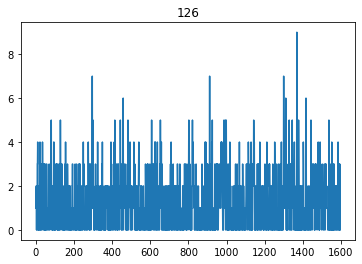

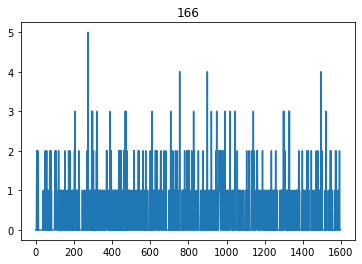

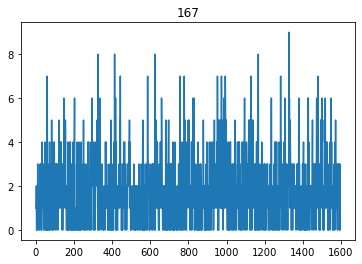

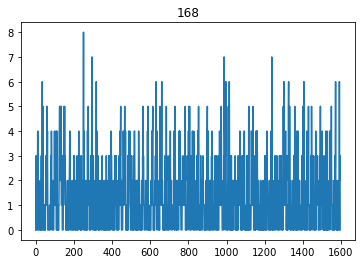

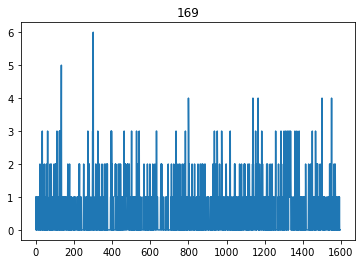

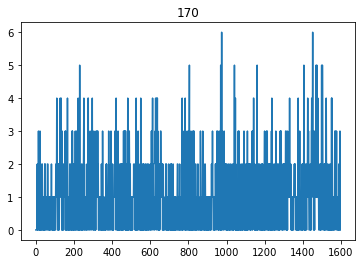

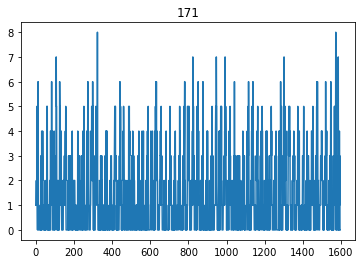

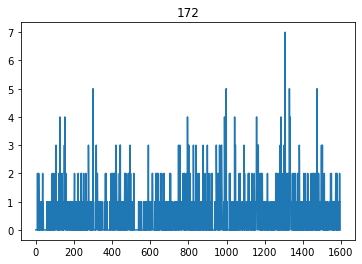

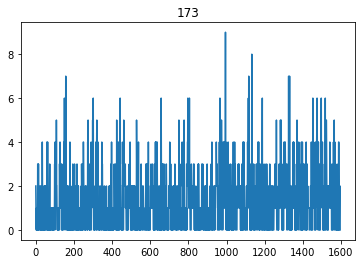

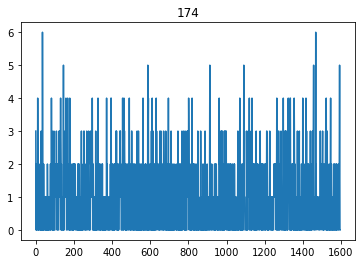

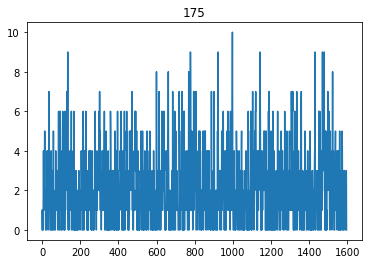

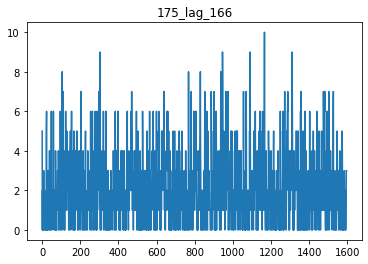

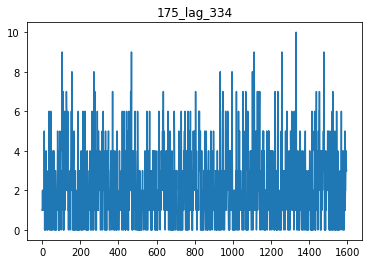

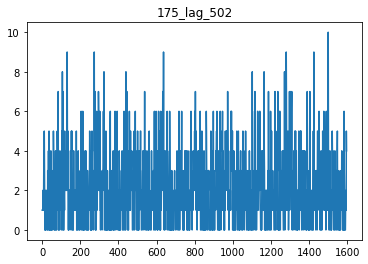

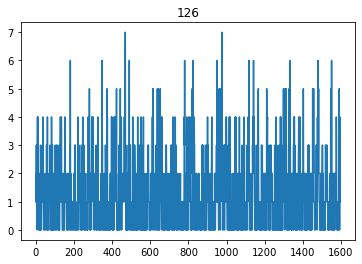

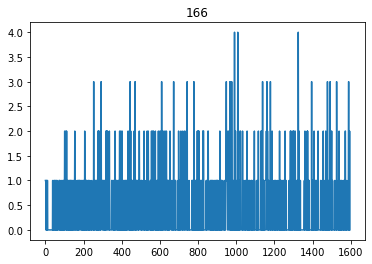

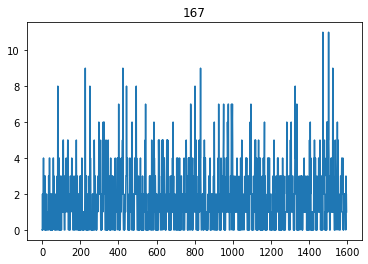

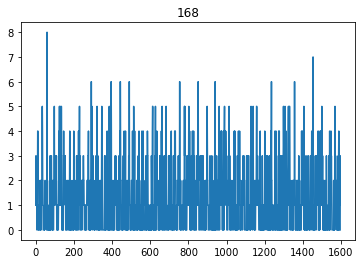

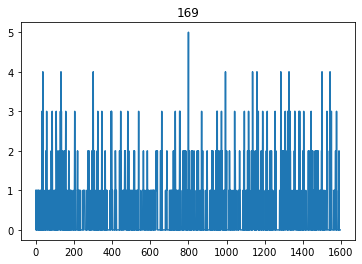

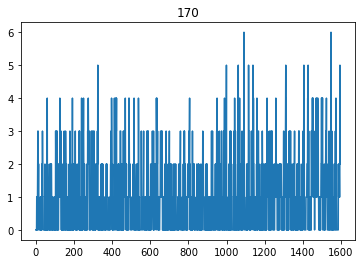

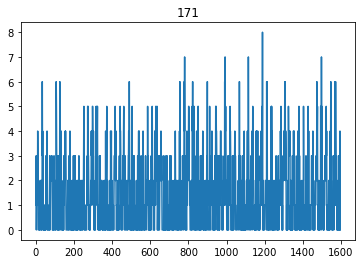

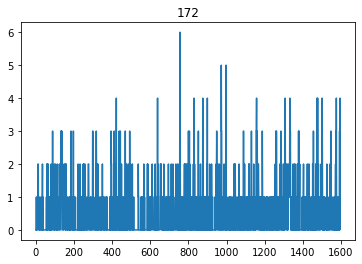

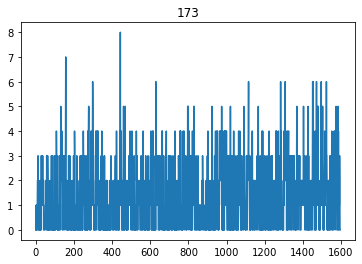

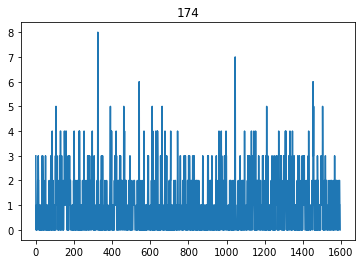

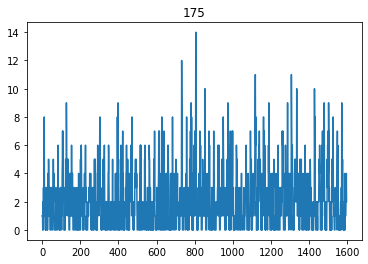

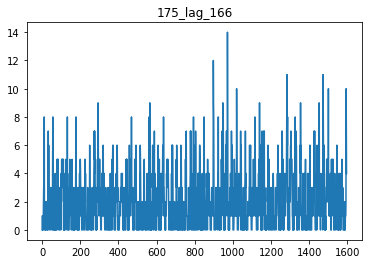

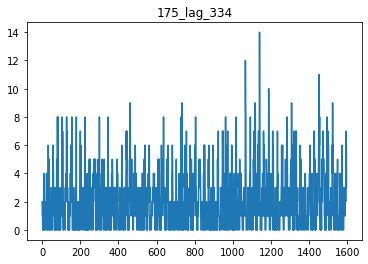

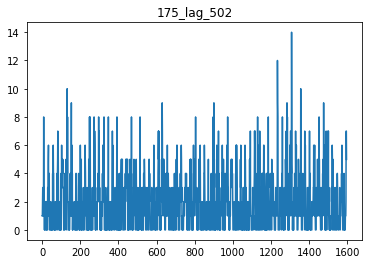

In [4]:
######### Viziualize and choose cluster here ######################
region_demand =  pd.read_csv('C:\Work\WORK_PACKAGE\Demand_forecasting\github\DeepAR-pytorch\My_model\\2_freq_nbinom_LSTM\\1_cluster_demand_prediction\data\demand_data\\tampines_region_demand_medium_dataset_lag_502.csv')
for i in region_demand.columns:
    plt.title(i)
    plt.plot(region_demand[i])
    plt.show()

# Visualize inflow
region_inflow = pd.read_csv('C:\Work\WORK_PACKAGE\Demand_forecasting\github\DeepAR-pytorch\My_model\\2_freq_nbinom_LSTM\\1_cluster_demand_prediction\data\demand_data\\tampines_region_inflow_medium_dataset_lag_502.csv')
for i in region_inflow.columns:
    plt.title(i)
    plt.plot(region_inflow[i])
    plt.show()

######### Viziualize and choose cluster here ######################

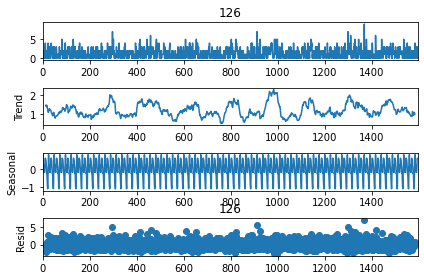

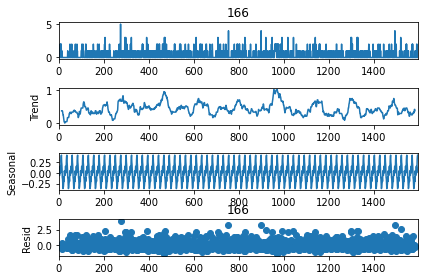

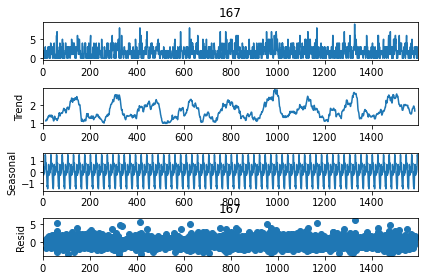

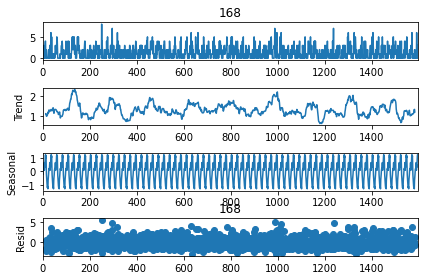

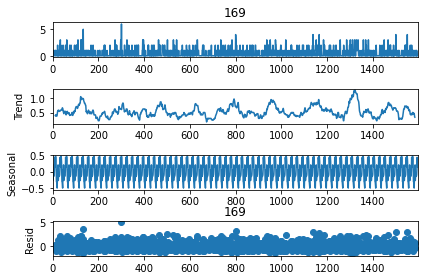

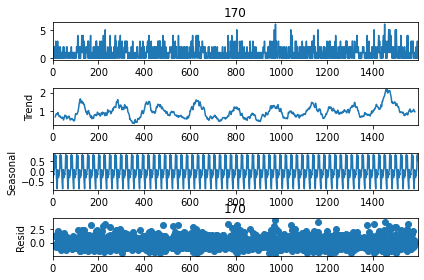

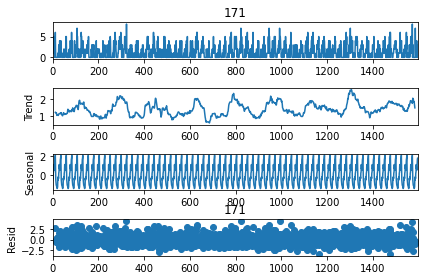

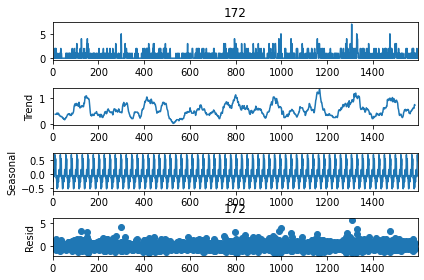

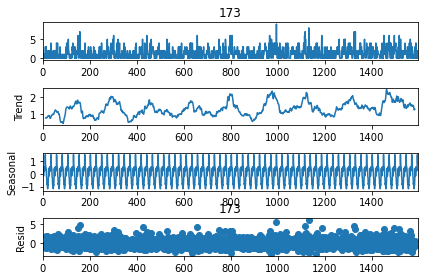

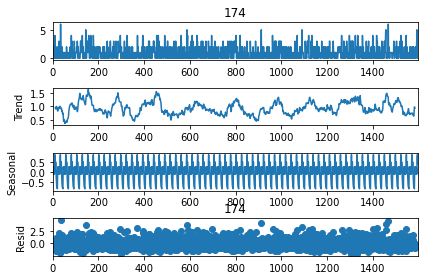

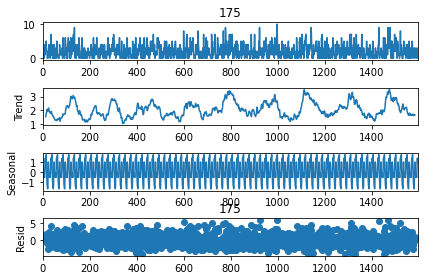

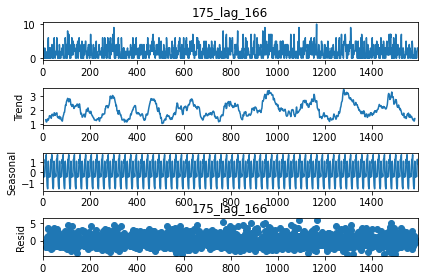

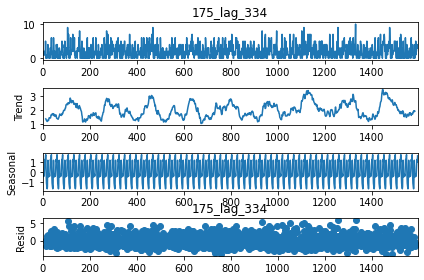

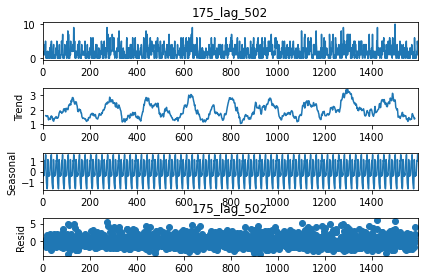

In [5]:
##### Decompose ALL numerical time series ###### 
for c in region_demand.columns:
    add = seasonal_decompose(region_demand[c], model='additive', period=24)
    add.plot()
    plt.title(c)
    plt.show()
    ## mul = seasonal_decompose(all_num_ts[c], model='multiplicative', period=1)
    ## mul.plot()
    ## plt.show()
##### Decompose ALL numerical time series ###### 

In [6]:
"""
set inputs here

"""
chosen = '175'
chosen_clstr = 'clstr_' + chosen # response cluster


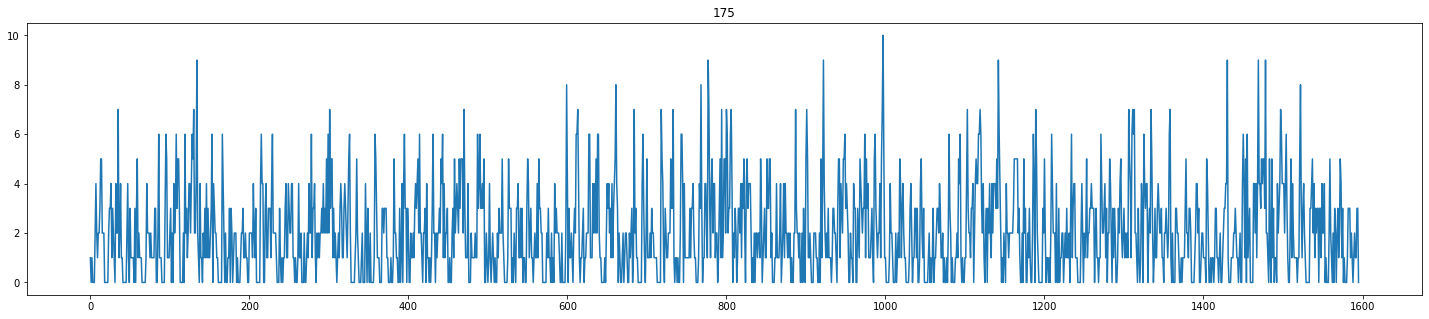

In [7]:
plt.figure(figsize=(25,5))
plt.plot(region_demand[chosen])
plt.title(chosen)
plt.show()

In [8]:
len(region_demand[chosen])

1596

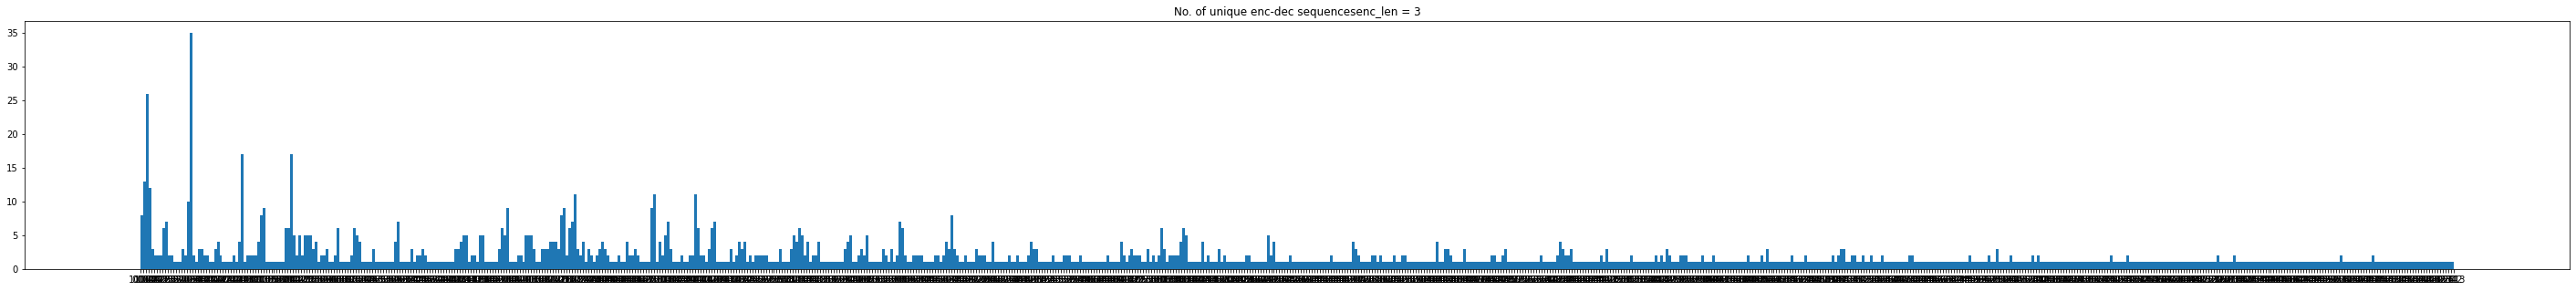

Data from cluster  175
out of  1592  enc-dec seq. there are  848 unique seq. for encoder length =  3
There are  744 enc-dec sequences that are same
There are  8586  number of same (ambiguous) encoder seq. with different decoder seq. for encoder length =  3


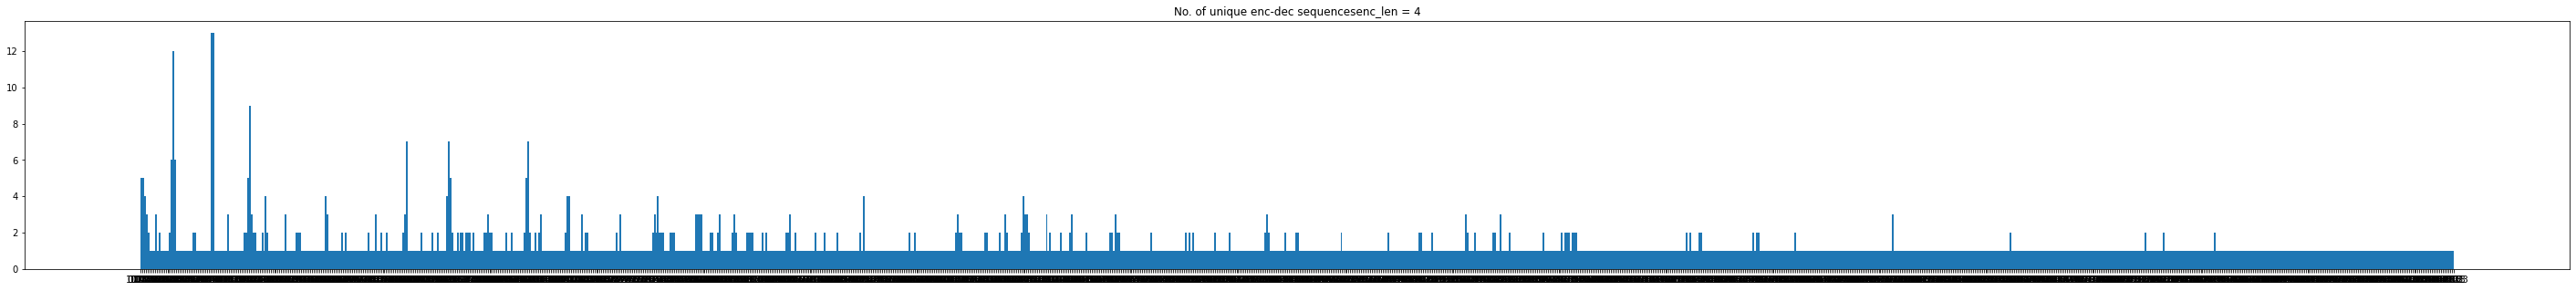

Data from cluster  175
out of  1591  enc-dec seq. there are  1280 unique seq. for encoder length =  4
There are  311 enc-dec sequences that are same
There are  2144  number of same (ambiguous) encoder seq. with different decoder seq. for encoder length =  4


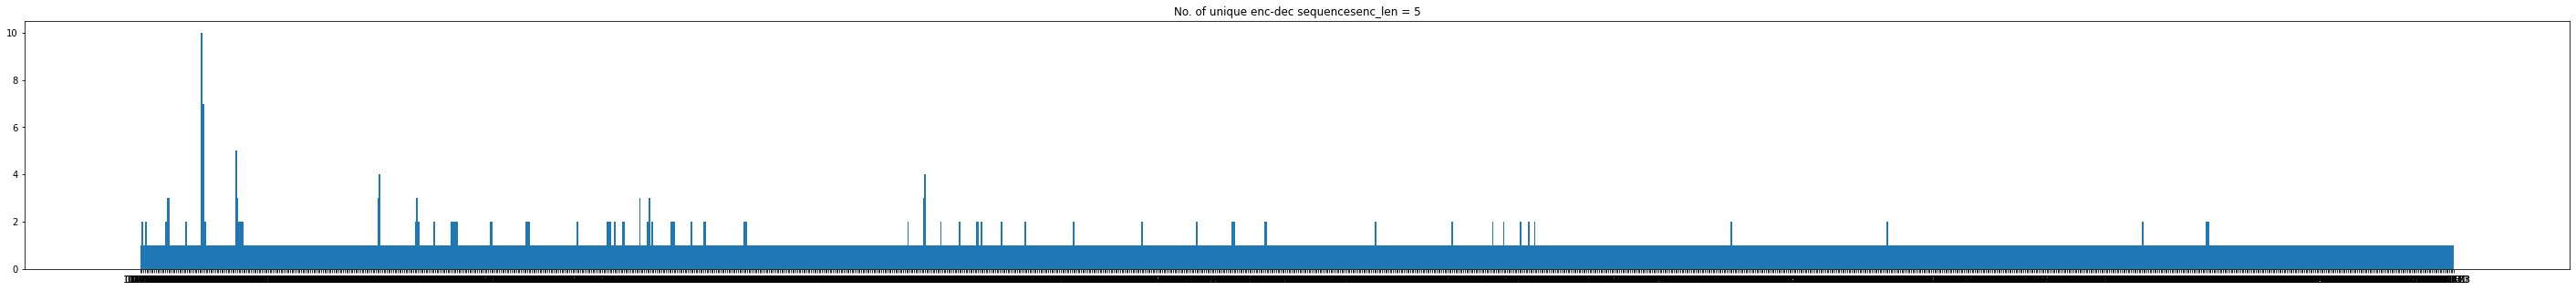

Data from cluster  175
out of  1590  enc-dec seq. there are  1484 unique seq. for encoder length =  5
There are  106 enc-dec sequences that are same
There are  502  number of same (ambiguous) encoder seq. with different decoder seq. for encoder length =  5


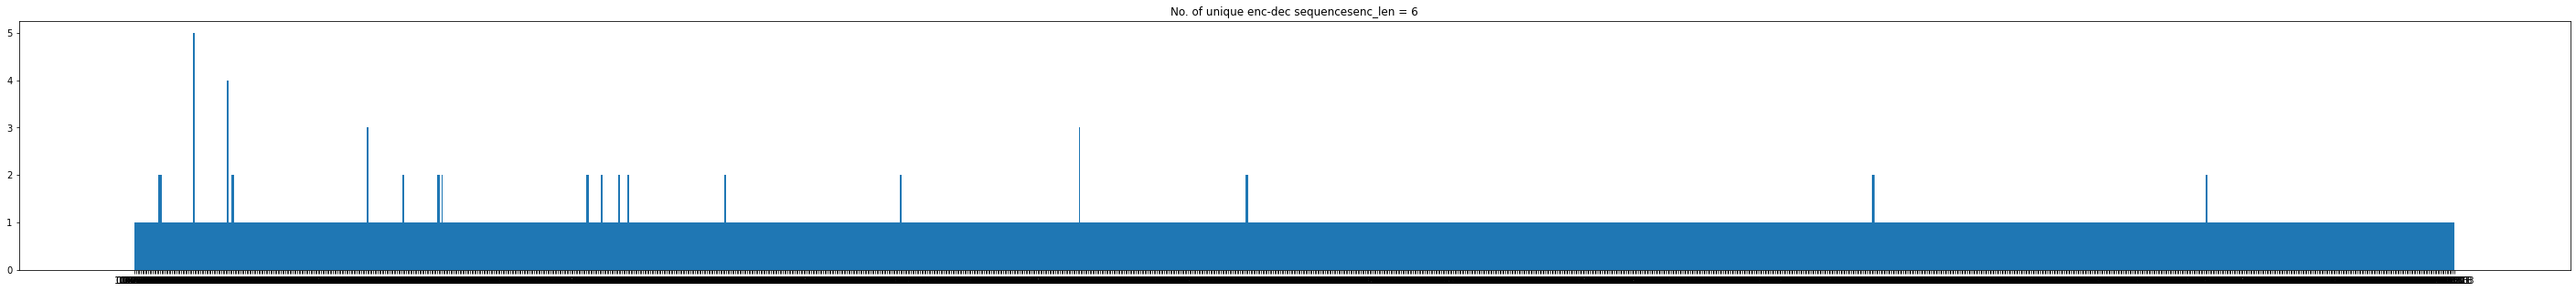

Data from cluster  175
out of  1589  enc-dec seq. there are  1558 unique seq. for encoder length =  6
There are  31 enc-dec sequences that are same
There are  135  number of same (ambiguous) encoder seq. with different decoder seq. for encoder length =  6


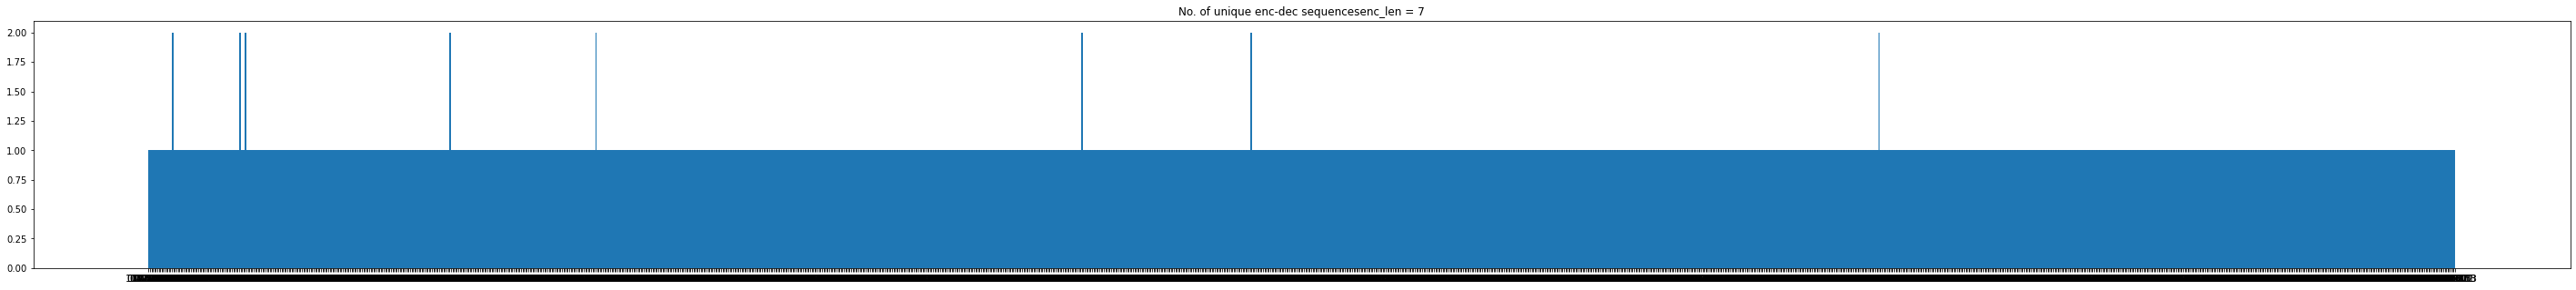

Data from cluster  175
out of  1588  enc-dec seq. there are  1580 unique seq. for encoder length =  7
There are  8 enc-dec sequences that are same
There are  34  number of same (ambiguous) encoder seq. with different decoder seq. for encoder length =  7


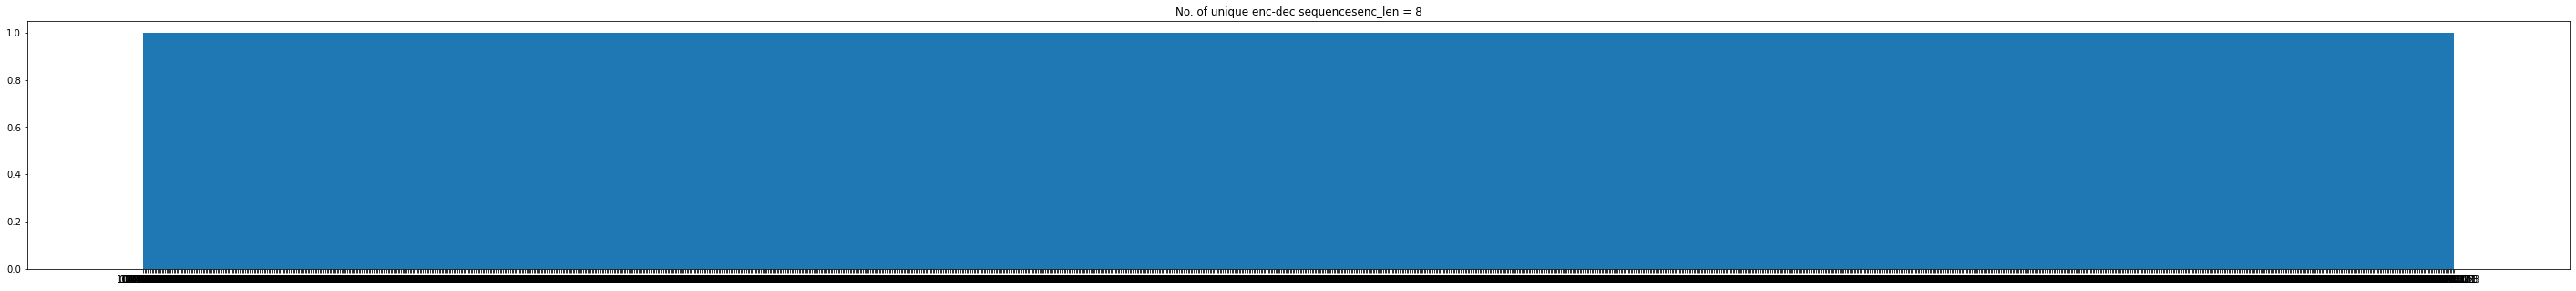

Data from cluster  175
out of  1587  enc-dec seq. there are  1587 unique seq. for encoder length =  8
There are  0 enc-dec sequences that are same
There are  8  number of same (ambiguous) encoder seq. with different decoder seq. for encoder length =  8


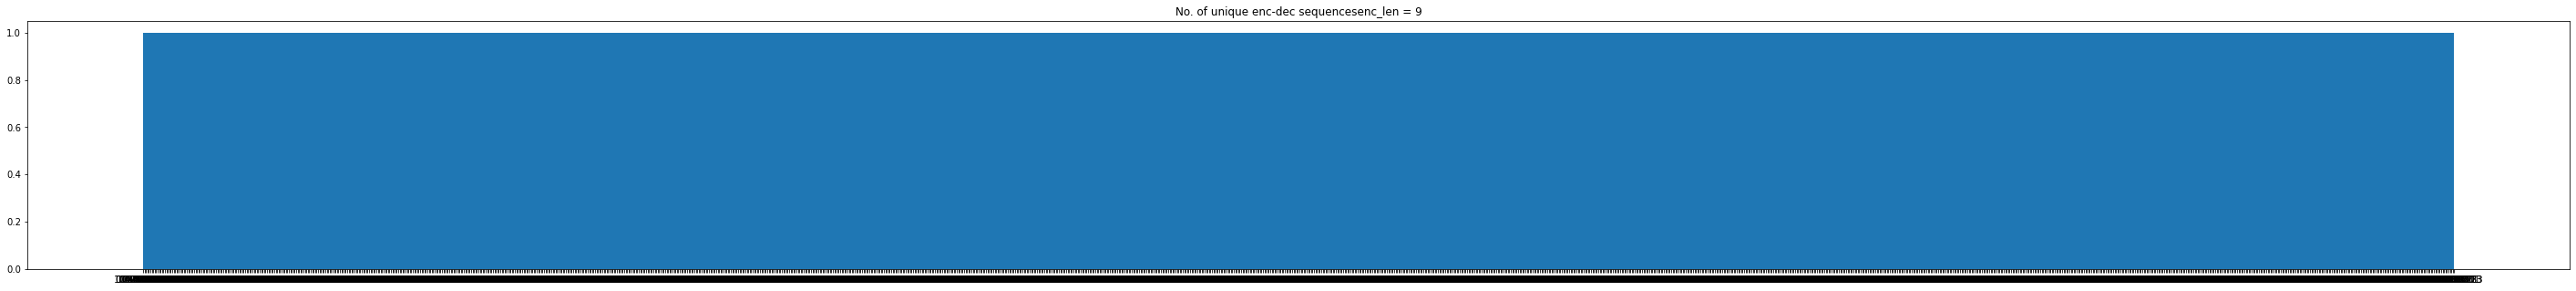

Data from cluster  175
out of  1586  enc-dec seq. there are  1586 unique seq. for encoder length =  9
There are  0 enc-dec sequences that are same
There are  0  number of same (ambiguous) encoder seq. with different decoder seq. for encoder length =  9


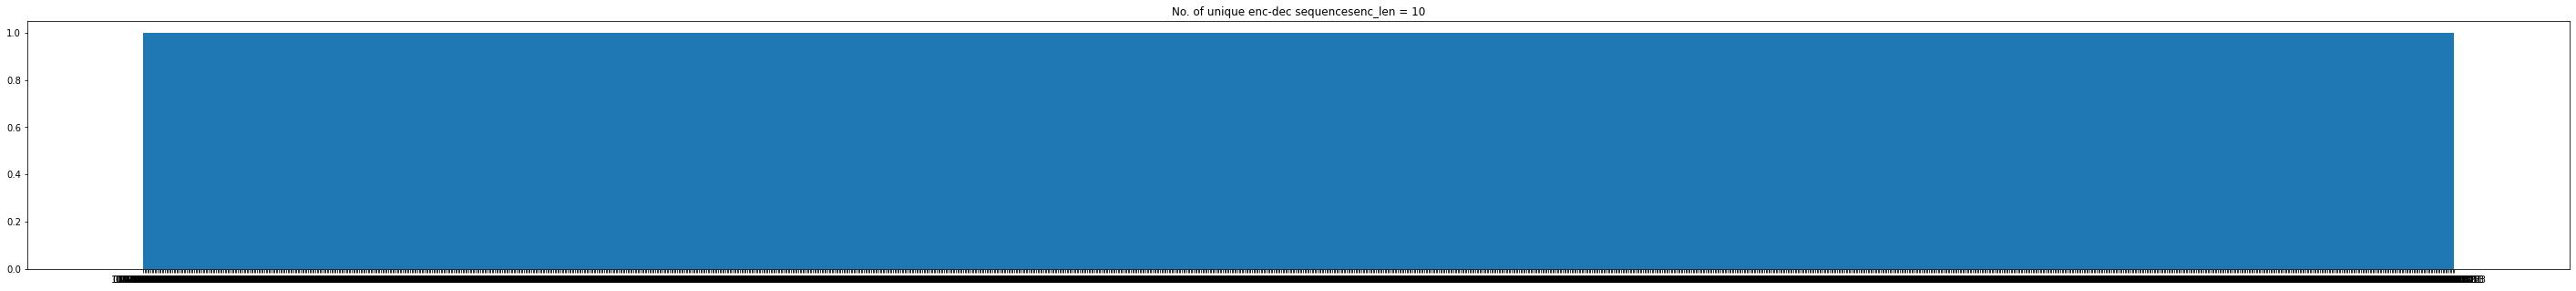

Data from cluster  175
out of  1585  enc-dec seq. there are  1585 unique seq. for encoder length =  10
There are  0 enc-dec sequences that are same
There are  0  number of same (ambiguous) encoder seq. with different decoder seq. for encoder length =  10


In [9]:
"""Encoder decoder unique data distribution

Encoder length is different for different input time series depeding on its data distribution. 

"""

e_len_list = range(3,11,1)
d_len = 1

for e_len in e_len_list:

    ########### histogram of unique encoder and decoder sequences ###############    
    tot_len = e_len + d_len

    df = pd.DataFrame()
    ed_seq = np.array([]) # enc-dec sequence
    ts = region_demand[chosen]  

    for i in range( len(ts) - tot_len):
        ed_seq_str = ''
        for j in ts[i:i+tot_len].to_numpy():
            ed_seq_str = ed_seq_str + str(j)

        ed_seq = np.append(ed_seq, ed_seq_str)

    df['ed_Seq'] = ed_seq

    df['ed_Seq'].hist(bins=df['ed_Seq'].nunique(),grid=False,legend=False,figsize=(50,5))
    plt.title('No. of unique enc-dec sequences'+'enc_len = '+str(e_len))
    plt.show()
    print('Data from cluster ', chosen)
    print('out of ', len(df['ed_Seq']),' enc-dec seq. there are ', df['ed_Seq'].nunique(), 'unique seq. for encoder length = ',e_len )
    print('There are ',  len(df['ed_Seq']) - df['ed_Seq'].nunique(), 'enc-dec sequences that are same')
    ########### histogram of unique encoder and decoder sequences ###############




    ########### identiy how many ed seq have same encoder but different decoder  #############

    amb_cnt = 0 # ambiguity counter

    for k in range(len(df['ed_Seq'])):
        enc_seq1 = df['ed_Seq'].loc[k][0:e_len]
        dec_seq1 = df['ed_Seq'].loc[k][e_len:]
        for l in range(k+1,len(df['ed_Seq']),1):
            enc_seq2 = df['ed_Seq'].loc[l][0:e_len]
            dec_seq2 = df['ed_Seq'].loc[l][e_len:]
            if ( (enc_seq1 == enc_seq2) and (dec_seq1 != dec_seq2)):
                amb_cnt+=1
                #print(enc_seq1,enc_seq2, dec_seq1, dec_seq2)

    print('There are ' ,amb_cnt,' number of same (ambiguous) encoder seq. with different decoder seq. for encoder length = ', e_len)

    ########### identiy how many ed seq have same encoder but different decoder  ##############


In [10]:
#df['ed_Seq'].loc[0]




In [11]:
df['ed_Seq'].loc[k]
df['ed_Seq'].loc[k][0:e_len]
df['ed_Seq'].loc[k][e_len:]

'3'

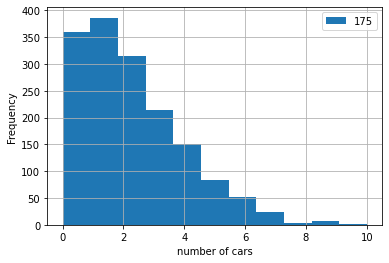

0.22556390977443608
0.24185463659147868
0.19674185463659147
0.13408521303258145
0.09461152882205513
0.05263157894736842
0.03195488721804511
0.015037593984962405
0.002506265664160401
0.0043859649122807015
0.0006265664160401002
sum =  1596
Optimization terminated successfully.
         Current function value: 1.869641
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
                     NegativeBinomial Regression Results                      
Dep. Variable:                    175   No. Observations:                 1596
Model:               NegativeBinomial   Df Residuals:                     1595
Method:                           MLE   Df Model:                            0
Date:                Wed, 18 Jan 2023   Pseudo R-squ.:               1.056e-11
Time:                        17:04:15   Log-Likelihood:                -2983.9
converged:                       True   LL-Null:                       -2983.9
Covariance Type:            nonrobust   

In [12]:
region_demand[chosen].hist(bins=region_demand[chosen].nunique(), grid=True,legend=True)
plt.ylabel('Frequency')
plt.xlabel('number of cars')
plt.show()


for category in range(11):
    print(len([1 for i in range(len(region_demand[chosen])) if region_demand[chosen].iloc[i] == category ])/1596) # count the number of cars in each category
print('sum = ', 360 + 386+314+214+151+84+51+24+4+7+1 )
import scipy


import statsmodels.api as sm
X = np.ones_like(region_demand[chosen])
res = sm.NegativeBinomial(region_demand[chosen],X).fit(start_params=[1,1])

print(res.summary())

k = 1/0.3519
p = k / ((10**0.7139) + k)

print(k,p)

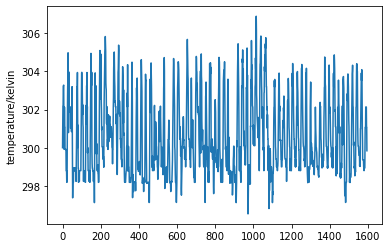

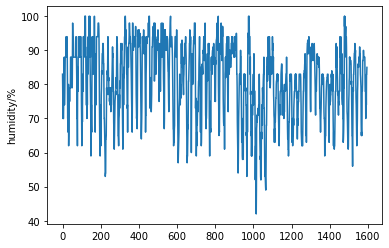

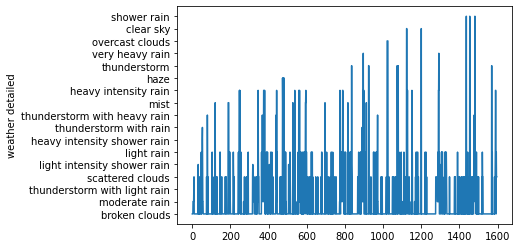

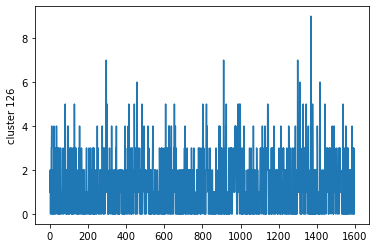

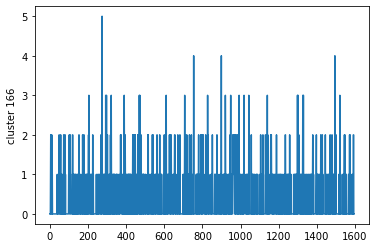

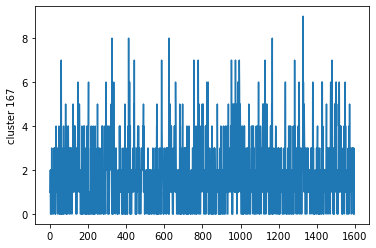

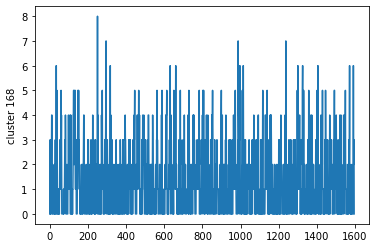

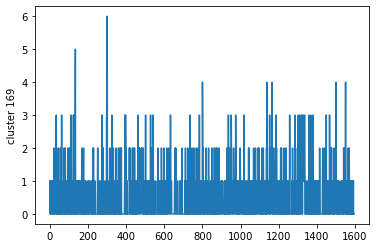

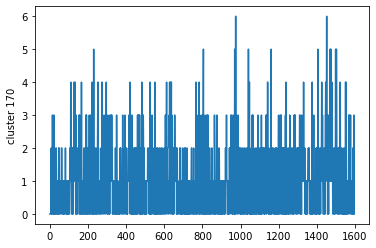

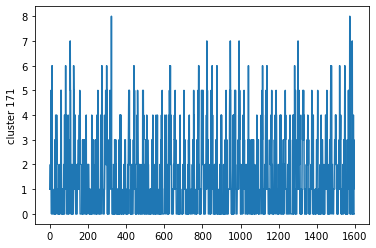

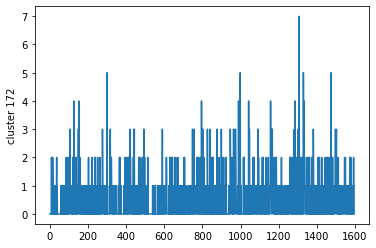

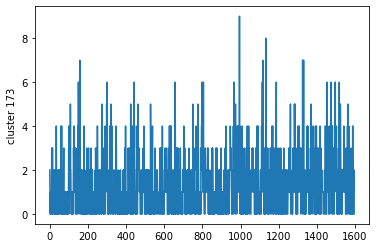

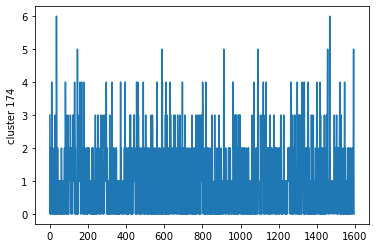

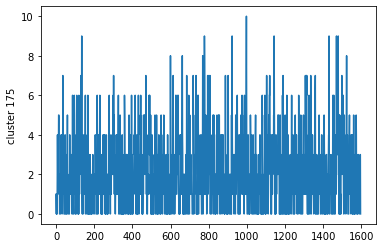

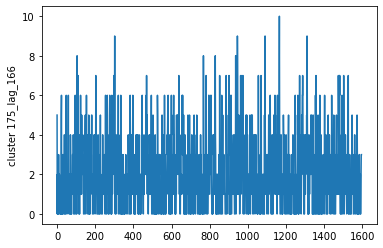

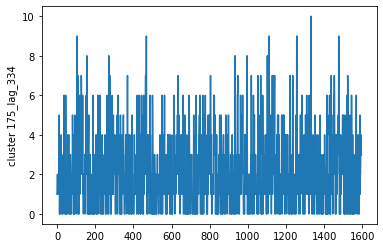

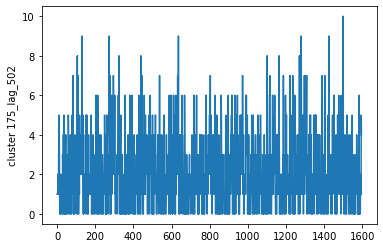

In [13]:
"""
Data Visulaization

"""

########## Read DATA  start ######################

########## Weather data ##########
tampines_clstr_175__weather =  pd.read_csv('C:\Work\WORK_PACKAGE\Demand_forecasting\github\DeepAR-pytorch\My_model\\2_freq_nbinom_LSTM\\1_cluster_demand_prediction\data\weather_data\\tampines_clstr_175_weather_medium_dataset.csv')

temp_clstr_175 = tampines_clstr_175__weather["temp_clstr_175"]
hum_clstr_175 = tampines_clstr_175__weather["hum_clstr_175"]
#wind_clstr_175 = tampines_region_weather["wind_clstr_175"]
#wea_clstr_175 = tampines_region_weather["wea_clstr_175"]
wea_desc_clstr_175 = tampines_clstr_175__weather["wea_desc_clstr_175"]
########## Weather data ##########



########## demand data clusters ##########
tampines_region_demand =  pd.read_csv('C:\Work\WORK_PACKAGE\Demand_forecasting\github\DeepAR-pytorch\My_model\\2_freq_nbinom_LSTM\\1_cluster_demand_prediction\data\demand_data\\tampines_region_demand_medium_dataset_lag_502.csv')
col_names = list(tampines_region_demand.columns)
reg_dem = {}
for c in col_names:
    reg_dem[c] = tampines_region_demand[c]
########## demand data clusters ##########

########## Read DATA  end ######################




########## Visualize DATA  start ######################

######### Visualize Weather DATA  ######################
plt.plot(temp_clstr_175)
plt.ylabel("temperature/kelvin")
plt.show()

plt.plot(hum_clstr_175)
plt.ylabel("humidity/%")
plt.show()

# plt.plot(wind_clstr_175)
# plt.ylabel("wind/ (m/s)")
# plt.show()

# plt.plot(wea_clstr_175)
# plt.ylabel("weather brief")
# plt.show()

plt.plot(wea_desc_clstr_175)
plt.ylabel("weather detailed")
plt.show()
######### Visualize Weather DATA  ######################

######### Visualize demand DATA  ######################
for c in col_names:
    plt.plot(tampines_region_demand[c])
    plt.ylabel(f"cluster {c}")
    plt.show()
######### Visualize demand DATA  ######################

########## Visualize DATA  end ######################

In [14]:
######## combine all numerical time series into a dictionary ##########
# all_num_ts = {'temp_clstr_175':temp_clstr_175,'hum_clstr_175':hum_clstr_175, 'wind_clstr_175':wind_clstr_175}
# for c in col_names:
#     all_num_ts['clstr_'+c] = reg_dem[c]

all_num_ts = {'temp_clstr_175':temp_clstr_175,'hum_clstr_175':hum_clstr_175}
for c in col_names:
    all_num_ts['clstr_'+c] = reg_dem[c]

######## combine all numerical time series into a dictionary ##########


In [15]:
"""
Data Analysis

# Need to check stationarity of all covariates.
# we do not stationarize non-stationary time series immediately,
# we do only if test error for the
# cluster is bad
"""

###### Check staionarity of ALL numerical time series ###### 
cov_stationary_flag = {}
col_names = all_num_ts.keys()

for c in col_names:
	result = adfuller(all_num_ts[c])
	if result[0] < (result[4]["1%"] and result[4]["5%"] and result[4]["10%"] ):
		cov_stationary_flag[c] = 1 # stationary
	else:
		cov_stationary_flag[c] = 0		

print('stationarity: ',cov_stationary_flag)
###### Check staionarity of ALL numerical time series ###### 

stationarity:  {'temp_clstr_175': 1, 'hum_clstr_175': 1, 'clstr_126': 1, 'clstr_166': 1, 'clstr_167': 1, 'clstr_168': 1, 'clstr_169': 1, 'clstr_170': 1, 'clstr_171': 1, 'clstr_172': 1, 'clstr_173': 1, 'clstr_174': 1, 'clstr_175': 1, 'clstr_175_lag_166': 1, 'clstr_175_lag_334': 1, 'clstr_175_lag_502': 1}


Sunday
2021-10-17 20:00:00  + period =  24


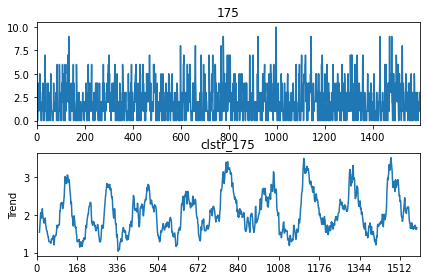

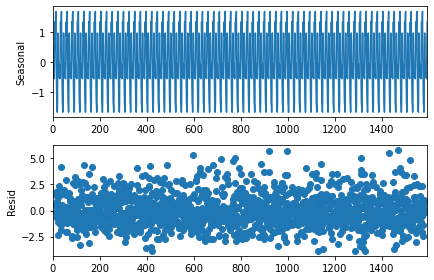

In [16]:
##### Decompose ALL numerical time series ###### 

period = 24
print('Sunday')
print(pd.Timestamp(year=2021, month=10, day=17, hour=20 ), ' + period = ', period)

start = 0
end = -1

for c in col_names:
    if c != 'clstr_175':
        continue
    add = seasonal_decompose(all_num_ts[c].iloc[start:end], model='additive', period=period,two_sided=True)
    add.plot(seasonal=False,resid=False)
    plt.title(c)
    plt.xticks(np.arange(start, len(all_num_ts[c].iloc[:end])+1, 168))
    add.plot(trend=False,observed=False)
    plt.show()
    ## mul = seasonal_decompose(all_num_ts[c], model='multiplicative', period=1)
    ## mul.plot()
    ## plt.show()
##### Decompose ALL numerical time series ######




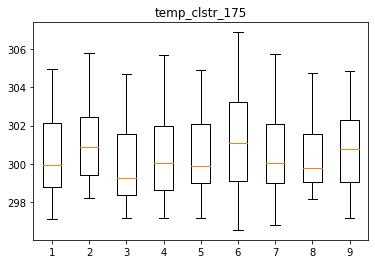

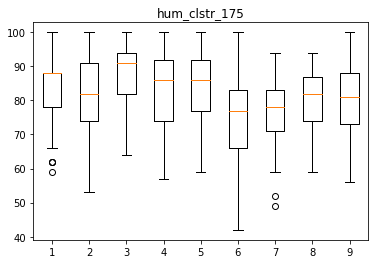

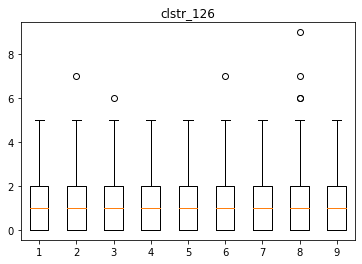

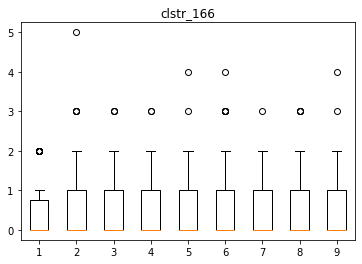

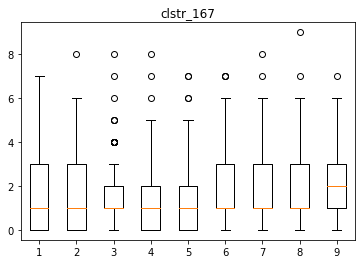

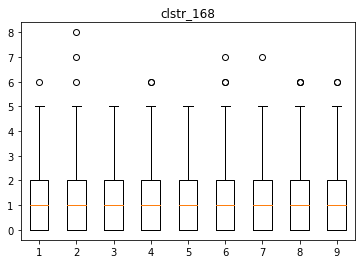

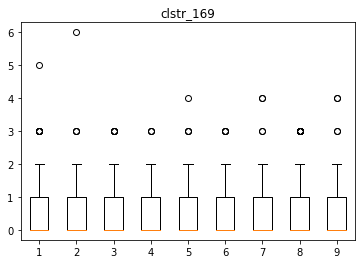

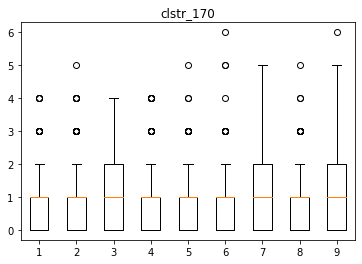

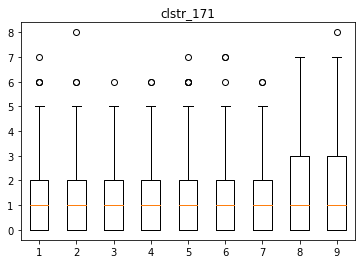

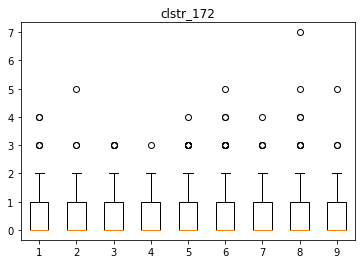

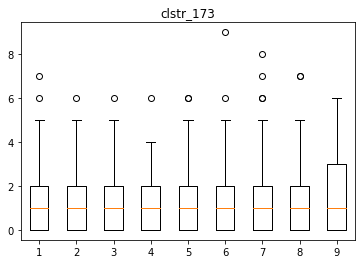

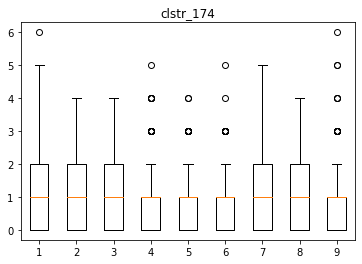

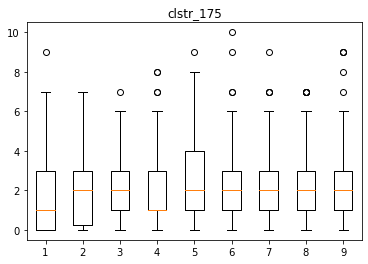

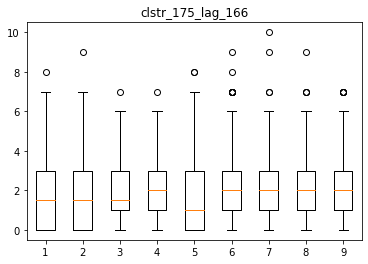

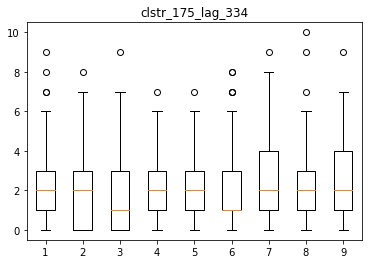

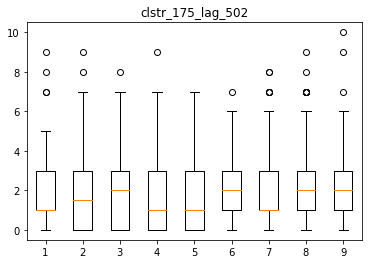

In [17]:
##### box plot of ALL numerical time series ###### 
win_size = 168
for c in col_names:
    ts_split = np.array_split(all_num_ts[c],len(all_num_ts[c])//win_size)
    plt.boxplot(ts_split)
    plt.title(c)
    plt.show()
##### box plot of ALL numerical time series ###### 

peak index: [ 12  24  36  48  60  72  84  96 108 120 132 144 156 168]


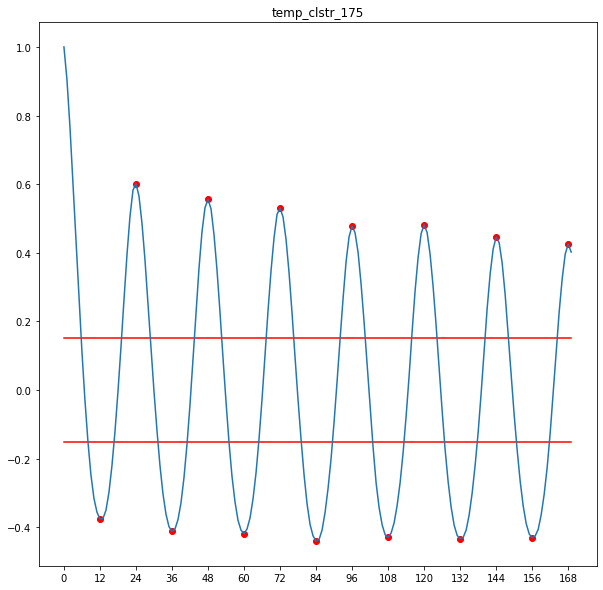

peak index: [ 13  24  36  48  60  72  84  96 108 120 132 144 156 168]


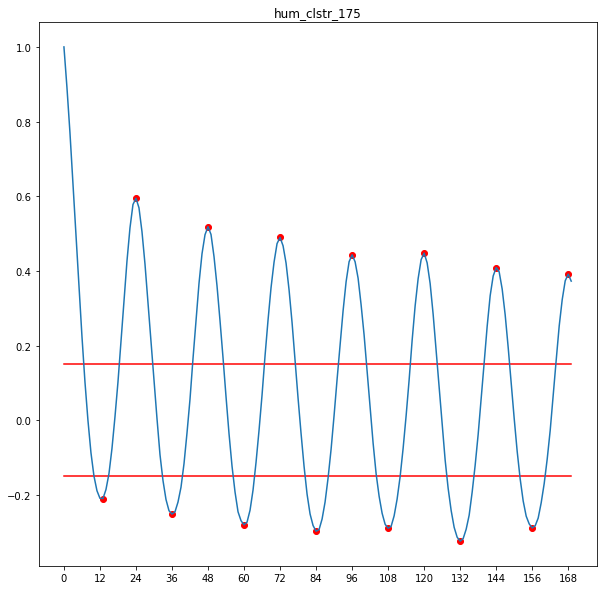

peak index: [  5   6   7  11  12  13  18  24  30  31  32  34  35  36  38  39  41  42
  43  48  52  53  55  58  59  61  65  72  78  79  80  81  82  85  89  91
  92  94  95  96  97  98 101 102 103 107 108 109 112 113 114 120 123 124
 126 127 128 130 131 134 135 136 137 144 148 149 151 156 157 158 161 162
 163 168]


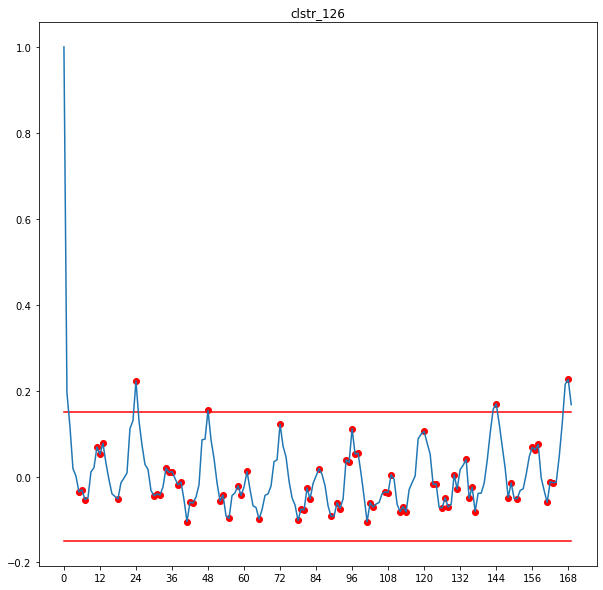

peak index: [  1   3   6   7   8   9  10  12  13  14  15  16  17  25  27  28  30  31
  32  34  35  36  37  40  41  42  43  44  45  47  48  49  50  51  54  55
  57  60  61  62  64  69  70  72  76  77  79  80  82  83  86  88  89  91
  92  93  94  95  96  97 104 106 107 109 110 111 112 115 116 119 120 121
 125 126 128 129 130 131 133 135 136 138 139 145 148 149 151 154 155 157
 159 162 163 165 166 168]


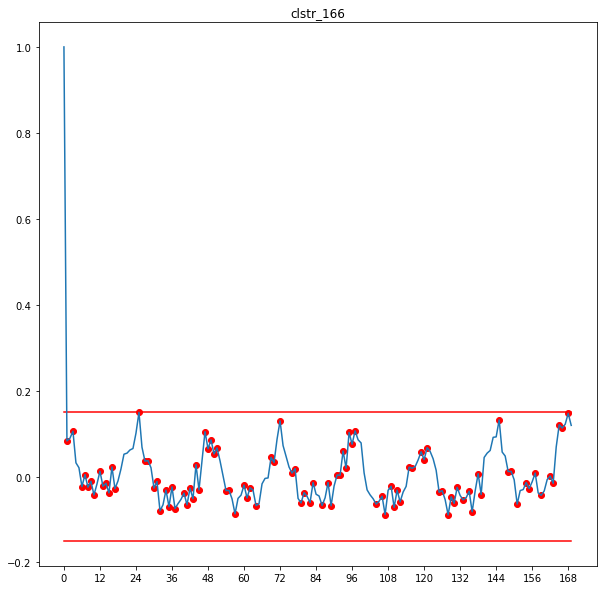

peak index: [  8  12  13  14  15  16  17  24  31  33  34  35  36  37  40  43  44  48
  54  55  56  57  58  59  61  62  64  72  79  80  81  82  83  85  86  87
  88  96  97  98 103 107 108 109 110 111 113 120 122 123 127 128 129 131
 136 144 151 152 153 156 161 168]


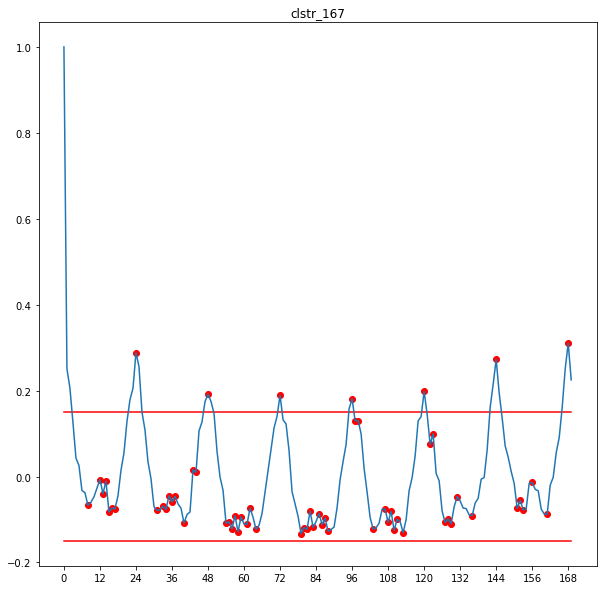

peak index: [  8   9  10  12  14  15  16  24  34  35  36  39  40  48  57  58  59  72
  80  81  84  86  87  96 106 107 108 120 130 132 134 135 136 144 151 152
 154 157 159 168]


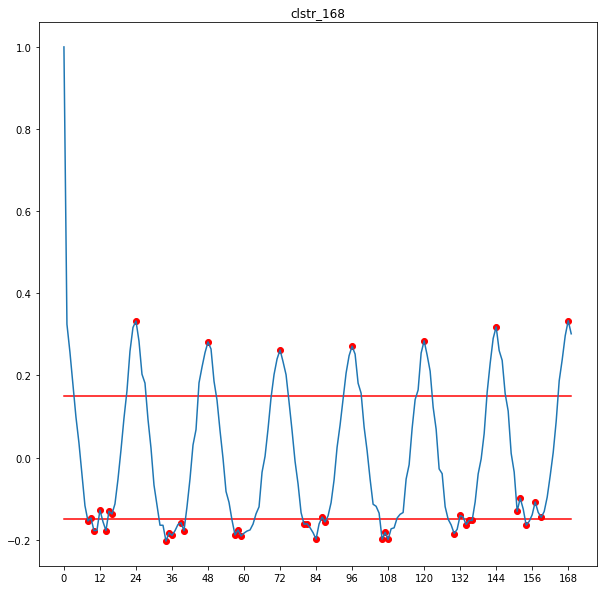

peak index: [  6  10  11  12  15  16  17  19  20  23  27  28  29  30  32  34  37  39
  40  46  47  48  49  50  55  57  58  60  61  63  64  66  67  70  71  72
  76  78  80  85  88  89  90  96  99 100 101 102 103 105 106 108 110 112
 113 114 115 117 118 119 121 122 126 132 133 135 137 139 140 142 143 144
 145 146 150 152 153 155 157 158 159 160 161 162 163 167 168]


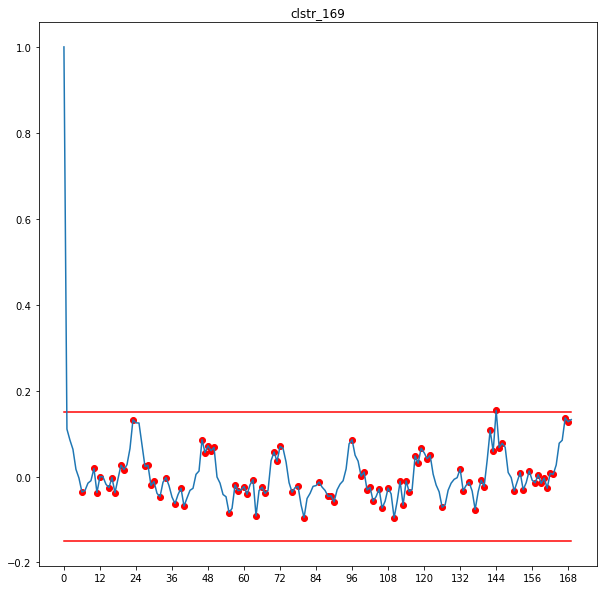

peak index: [  4   5   7   8  11  12  13  16  17  18  19  21  22  24  32  33  36  37
  38  39  41  44  45  49  54  55  58  59  60  61  62  64  65  68  70  73
  76  77  80  83  85  89  90  95  96  97 104 105 106 107 109 111 113 114
 115 120 124 125 126 127 129 130 131 132 134 135 136 140 141 144 151 153
 154 156 157 158 159 160 161 167]


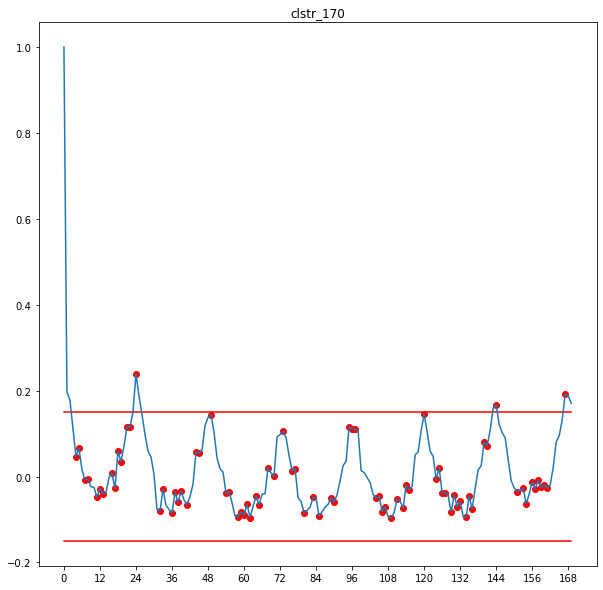

peak index: [ 11  13  14  24  35  37  38  48  59  72  84  96 107 108 109 120 134 144
 155 168]


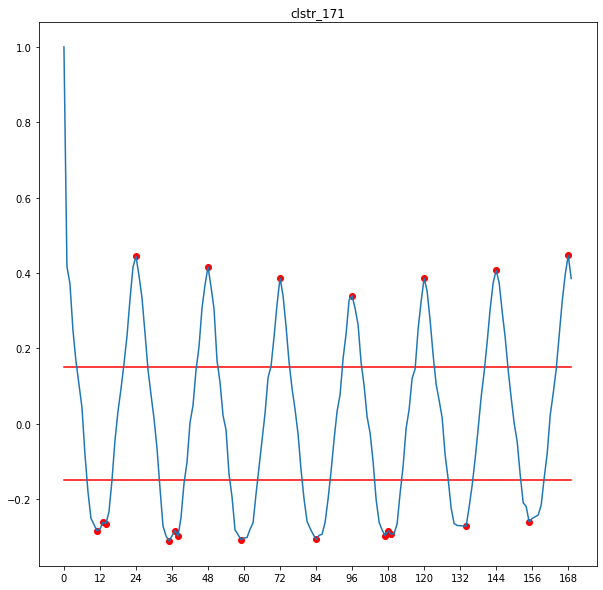

peak index: [ 10  11  12  13  14  15  16  17  18  20  21  22  23  24  27  28  30  31
  32  33  36  37  38  39  40  44  45  46  47  48  51  52  56  58  60  62
  63  68  69  70  71  72  74  75  78  79  81  83  84  86  88  93  94  96
  97  98  99 100 101 102 105 107 108 110 112 115 116 120 122 123 127 128
 129 130 131 134 136 137 138 143 144 145 147 148 149 150 153 155 156 159
 160 168]


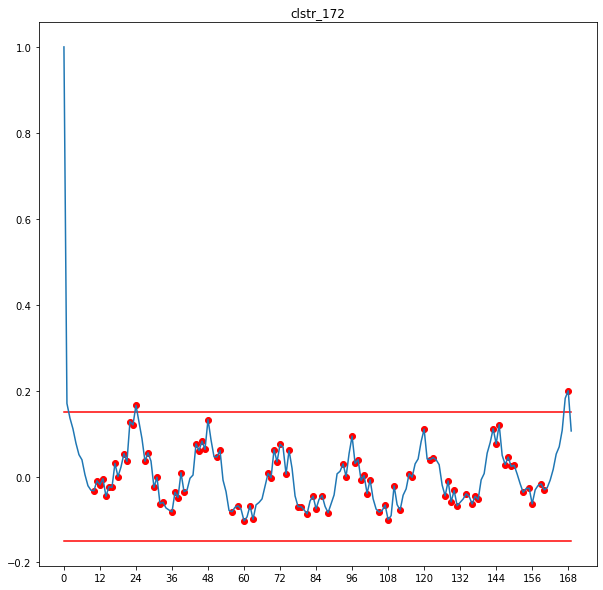

peak index: [  8   9  10  11  12  14  16  19  20  21  22  24  32  35  36  37  38  48
  57  58  60  62  63  67  68  72  80  81  82  84  85  86  88  92  94  95
 106 111 112 119 121 122 128 129 131 132 134 141 142 144 147 148 151 152
 153 154 155 156 157 159 160 168]


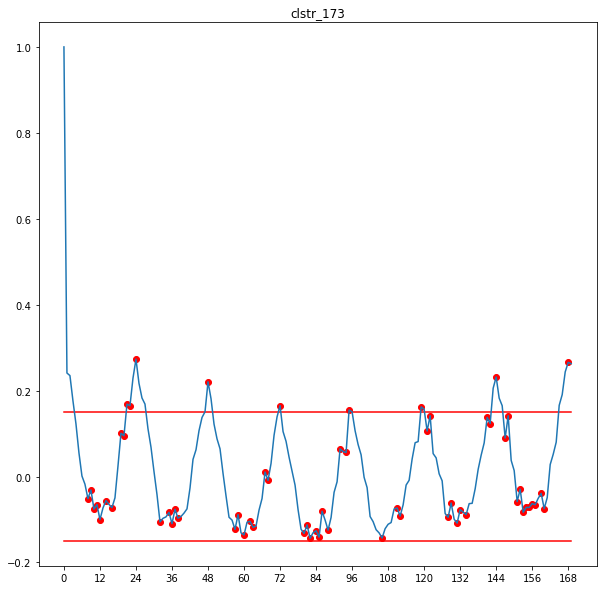

peak index: [  6   9  10  13  16  24  32  36  40  41  42  48  55  57  59  60  65  67
  68  72  79  81  82  83  85  86  89  90  91  96 104 106 107 108 109 110
 113 119 127 129 130 131 134 136 137 138 139 140 141 144 151 155 156 157
 158 159 161 168]


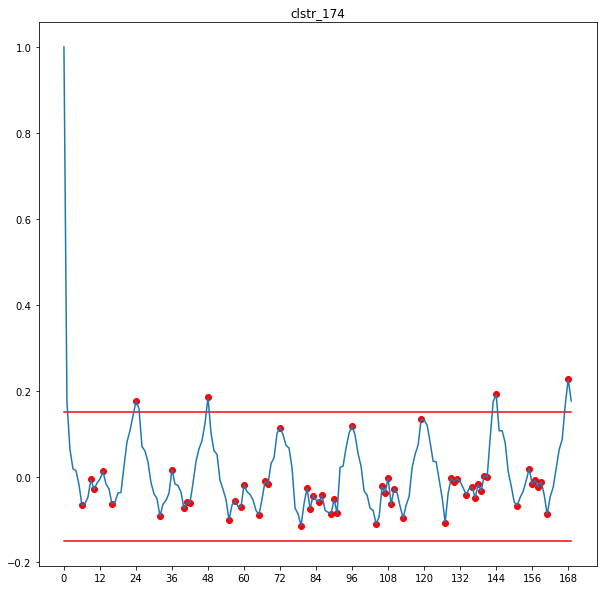

peak index: [  7  12  16  17  18  24  31  34  36  37  38  39  42  48  55  58  60  61
  65  72  79  82  83  84  85  86  90  96 102 106 109 110 113 120 127 132
 133 134 137 144 151 157 162 168]


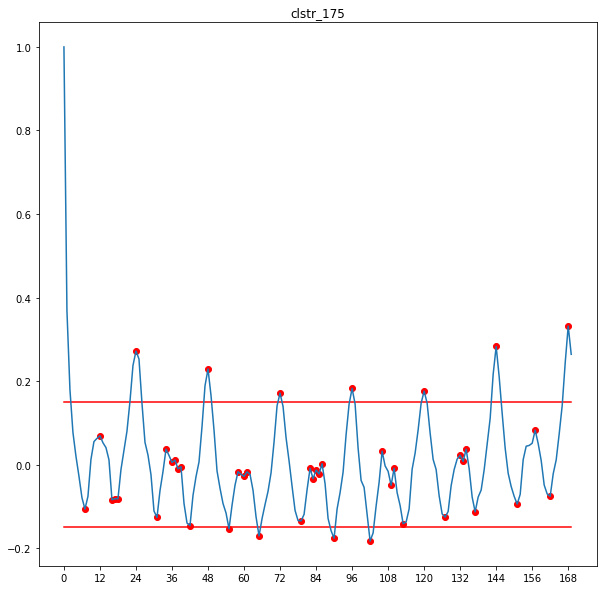

peak index: [  7  11  17  24  31  34  36  37  38  39  42  48  55  58  60  62  65  72
  79  82  83  84  85  86  89  96 102 106 109 110 113 120 128 132 133 134
 137 144 151 154 155 157 161 168]


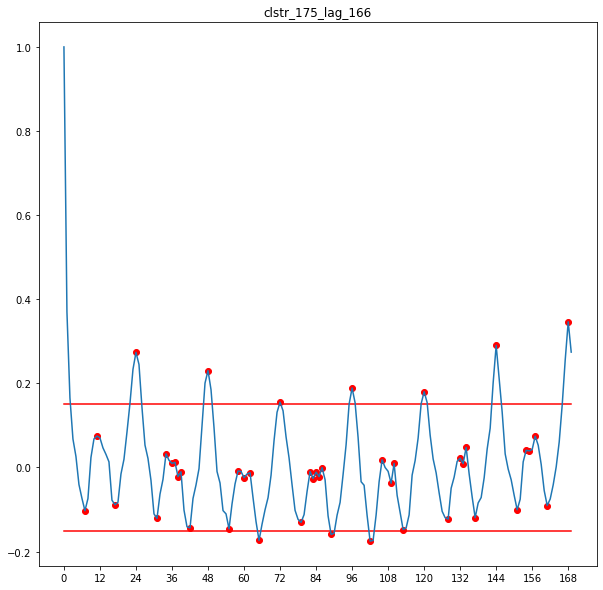

peak index: [  7  10  11  12  17  24  31  34  36  37  42  48  55  59  60  61  65  72
  79  82  83  84  85  86  89  96 102 106 109 110 113 120 127 132 133 134
 137 144 151 155 156 157 161 168]


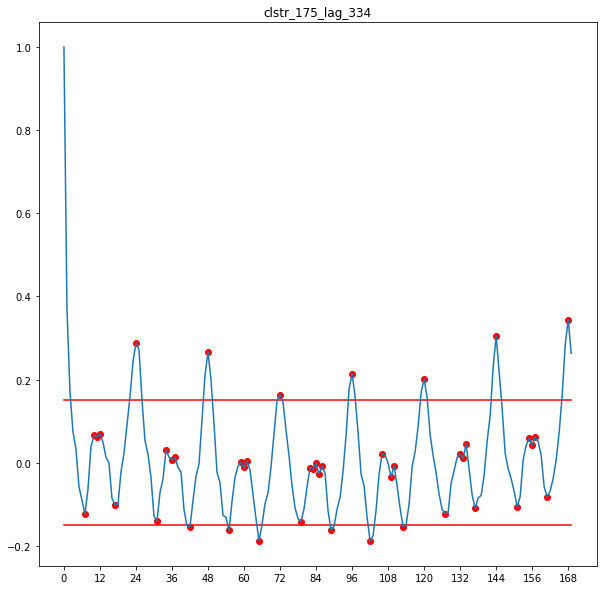

peak index: [  7  10  11  12  18  24  31  34  42  48  55  59  60  61  65  73  79  84
  85  86  89  96 102 107 109 110 114 120 127 132 133 134 137 144 151 155
 156 157 161 168]


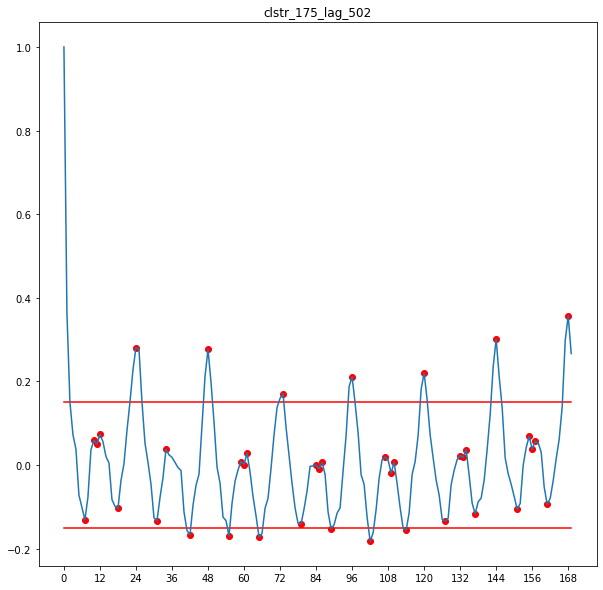

In [18]:
###### ACF plot of ALL numerical time series ###### 
peak_idx_acf = np.array([])
view_lags = 169
for c in col_names:
    acf1 = acf(all_num_ts[c], nlags=view_lags)
    peak_idx_high = np.array((find_peaks(acf1,height=(-0.7,0.7))[0]),dtype=int)
    peak_idx_low = np.array((find_peaks(-1*acf1,height=(-0.7,0.7))[0]),dtype=int)
    peak_idx_acf = np.sort(np.concatenate((peak_idx_high, peak_idx_low),axis=0))
    print(f'peak index: {peak_idx_acf}')
    x = list(range(0,len(acf1)))
    plt.figure(figsize=(10,10))
    plt.plot(x,[1.96/np.sqrt(len(x))]*len(x), 'r')
    plt.plot(x,[(-1*1.96)/np.sqrt(len(x))]*len(x),'r')
    plt.plot(x,acf1)
    plt.xticks(np.arange(0, len(x),12))
    plt.scatter(peak_idx_high,acf1[peak_idx_high],color='red')
    plt.scatter(peak_idx_low,acf1[peak_idx_low],color='red')
    plt.title(c)
    plt.show()

# use peak_idx_acf to pick the first 50 lags

###### ACF plot of ALL numerical time series ###### 

peak index: [  2   4   5   7   8  10  12  20  24  27  28  29  32  34  35  36  37  43
  44  45  50  51  53  54  55  57  58  59  60  61  62  63  64  65  66  67
  68  71  72  73  75  76  77  78  80  83  84  87  88  90  91  94  95  96
  97  98  99 100 102 105 106 108 110 111 112 116 118 119 121 123 125 126
 127 128 129 131 133 135 136 137 138 140 142 143 145 147 148 149 150 151
 152 153 154 156 158 159 161 163 164 165 166 167 169 171 173 175 177 179]


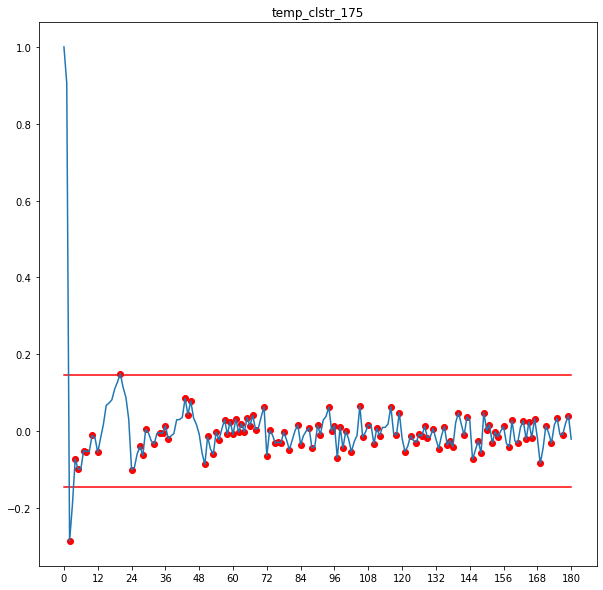

peak index: [  3   4   5   6   7   8   9  11  12  14  15  16  18  19  20  21  26  27
  28  29  30  31  32  33  35  36  37  38  39  41  42  43  44  45  47  48
  50  51  52  53  54  56  58  59  60  63  65  67  68  69  70  71  73  74
  77  78  80  83  84  85  87  88  89  91  92  93  97  98  99 100 101 105
 107 108 109 110 112 113 114 116 117 119 121 122 123 125 127 128 131 132
 133 134 135 136 138 141 143 144 146 147 149 150 151 152 153 155 156 157
 158 159 161 163 164 165 166 167 169 170 171 172 173 174 176 178 179]


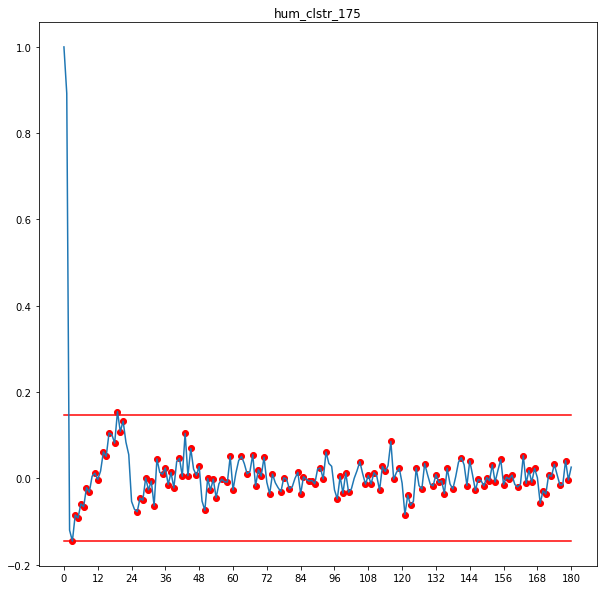

peak index: [  3   4   5   6   7   9  10  11  12  13  16  19  20  22  23  24  27  28
  30  31  33  34  35  36  37  39  41  42  44  46  47  48  52  53  55  56
  59  61  63  64  65  67  69  70  71  72  73  74  76  77  78  79  80  81
  82  84  85  86  90  91  92  94  95  96  97  98 101 102 105 106 108 110
 111 113 114 116 117 118 123 124 125 127 129 130 131 132 133 134 135 136
 137 138 140 143 148 149 152 158 160 162 164 167 169 170 172 173 176 177
 178 179]


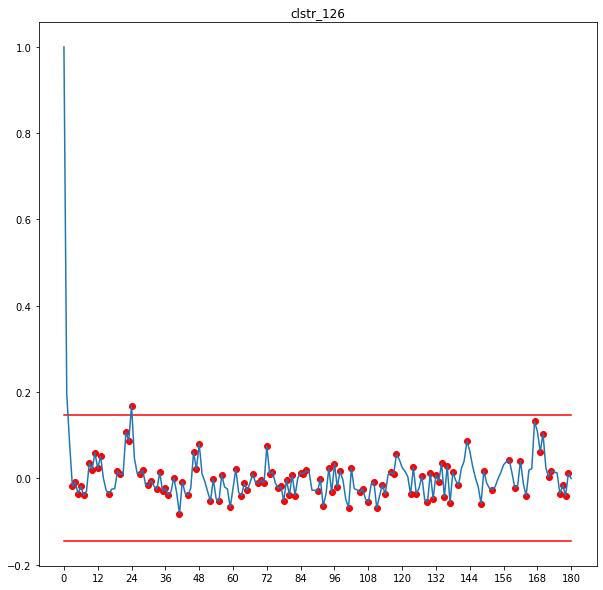

peak index: [  2   3   6   7   8   9  10  12  13  14  15  16  17  20  21  22  23  25
  27  29  30  31  32  34  35  36  37  40  41  42  43  44  45  47  48  49
  50  51  54  55  56  60  61  62  65  66  68  69  70  72  75  77  78  81
  82  83  84  85  86  88  89  90  91  93  94  95  96  97  98  99 102 103
 104 105 107 109 110 111 112 115 118 119 120 122 125 126 128 129 130 131
 134 135 136 138 139 141 143 145 146 147 148 149 151 154 155 156 159 162
 163 165 166 168 169 171 172 173 174 175 177 178 179]


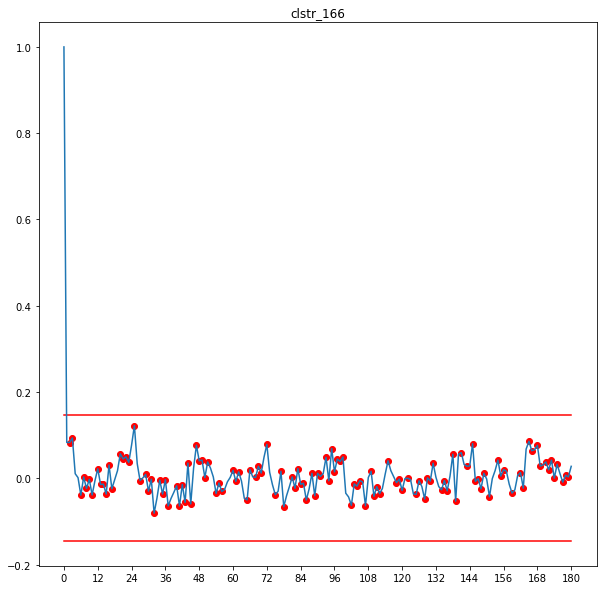

peak index: [  4   5   6   7   8  12  13  14  15  22  23  24  26  27  28  29  30  33
  34  35  36  37  38  39  40  41  42  43  44  45  46  47  49  50  52  53
  54  55  56  57  58  59  60  62  64  72  73  74  76  78  79  80  81  82
  83  85  86  87  88  89  90  92  94  95  97  99 102 106 108 109 110 111
 113 115 117 118 119 120 122 123 124 125 127 128 129 131 135 138 140 144
 147 150 151 152 154 155 157 158 161 162 163 164 165 168 169 170 171 172
 173 174 177 178 179]


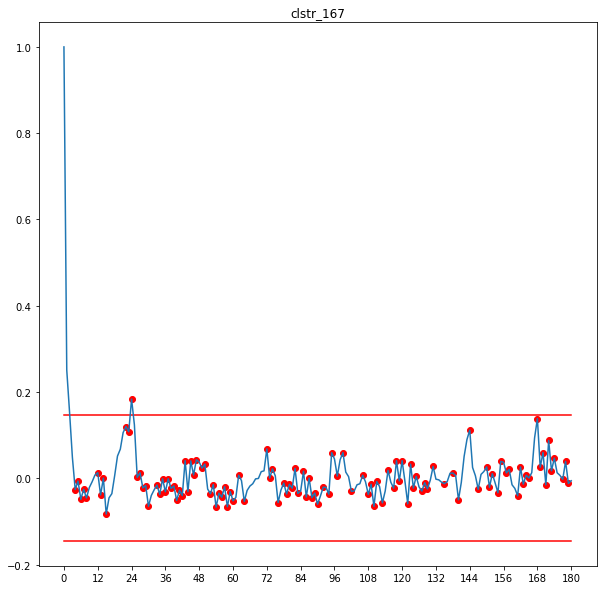

peak index: [  7   9  10  12  14  15  16  23  26  27  30  31  32  33  34  35  36  38
  40  43  44  45  47  49  50  51  52  53  54  55  57  59  60  63  65  66
  67  69  70  72  73  74  76  77  79  81  84  85  88  89  90  92  93  96
  98  99 100 102 103 104 106 107 108 109 110 111 113 114 115 117 118 120
 123 124 125 126 127 132 134 135 136 138 139 143 145 146 147 148 149 150
 151 152 154 157 159 168 169 170 172 173 174 176 177]


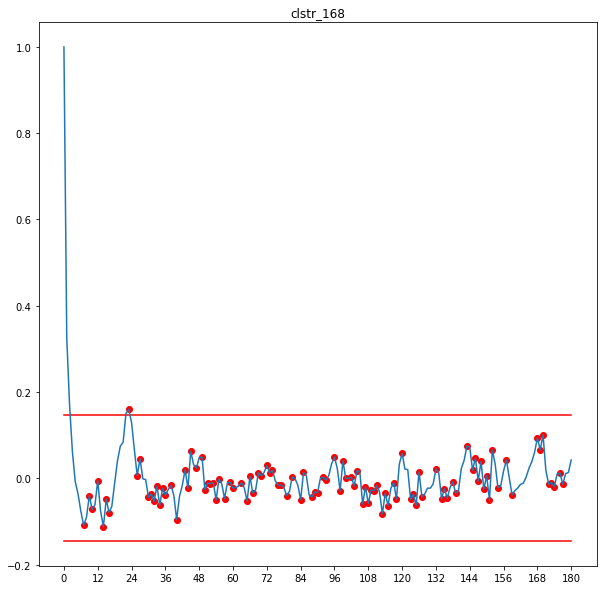

peak index: [  6  10  11  12  15  16  17  19  20  23  27  28  29  30  32  34  37  39
  40  42  43  46  47  48  49  50  51  52  53  54  55  57  58  60  61  63
  64  65  68  70  71  72  75  78  80  83  88  89  90  92  93  95  97  98
  99 100 101 102 103 105 106 108 110 112 113 114 116 117 118 119 120 122
 124 125 126 129 131 132 133 134 137 139 140 142 143 144 145 147 148 149
 150 152 154 155 157 158 159 160 161 162 163 167 168 169 171 172 174 175
 178]


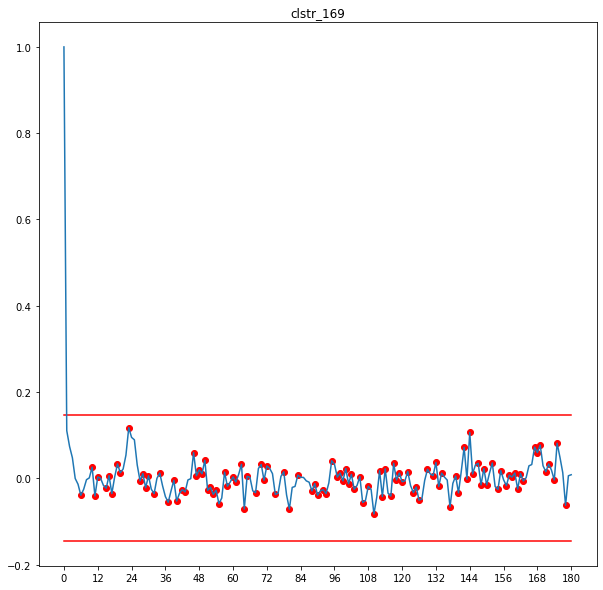

peak index: [  4   5   7   8   9  10  11  12  13  16  17  18  19  21  22  24  28  29
  31  33  36  37  38  39  42  44  45  47  51  53  54  55  57  59  60  61
  62  64  65  66  67  68  70  71  74  75  76  77  78  79  80  83  85  87
  90  91  92  95  97  98  99 102 103 105 106 107 108 111 113 114 116 117
 118 120 122 123 124 125 126 128 129 130 133 135 136 138 139 140 141 143
 145 147 149 153 154 156 159 160 162 167 169 170 172 173 174 178]


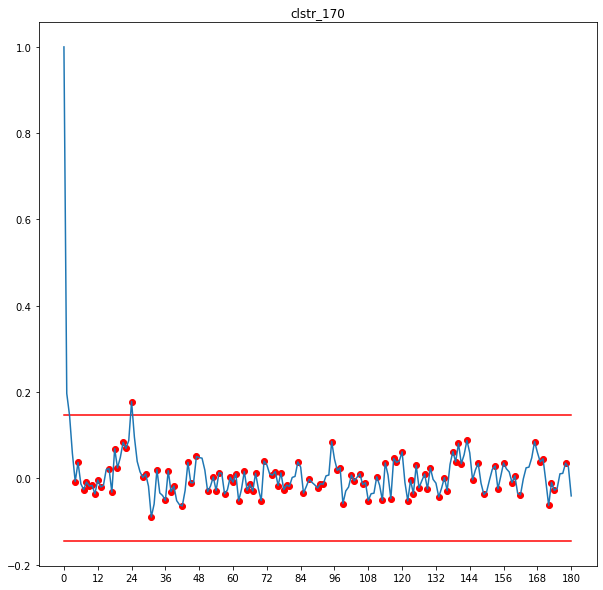

peak index: [  8  13  14  17  19  23  28  31  33  37  38  40  41  42  43  48  51  52
  53  54  55  56  57  58  61  62  63  64  66  68  69  72  75  78  79  82
  84  85  86  87  88  91  92  93  94  95  97  98  99 100 101 103 104 106
 110 114 115 116 117 120 122 123 124 126 127 128 130 131 134 135 137 144
 146 147 150 151 153 154 155 157 159 162 164 168 170 173 174 175 177 178
 179]


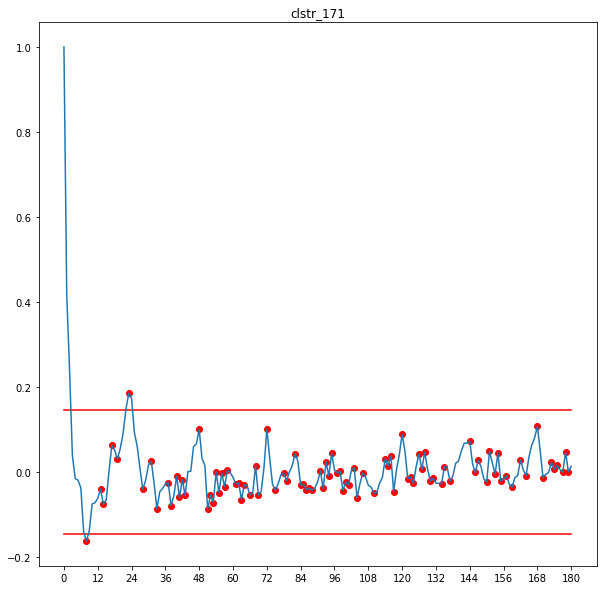

peak index: [  8  11  12  13  14  15  16  17  18  20  21  22  23  24  27  28  30  31
  32  33  35  37  38  39  41  44  45  46  47  48  50  52  55  58  61  62
  63  64  65  67  69  70  71  72  74  75  77  80  81  82  84  86  88  91
  92  93  94  96  97  98  99 100 101 102 104 105 106 107 108 110 112 113
 114 115 116 117 118 120 121 123 124 125 127 128 129 130 131 133 135 139
 140 143 144 145 147 151 154 155 156 157 158 160 162 164 165 168 169 171
 174 175 176 177 178 179]


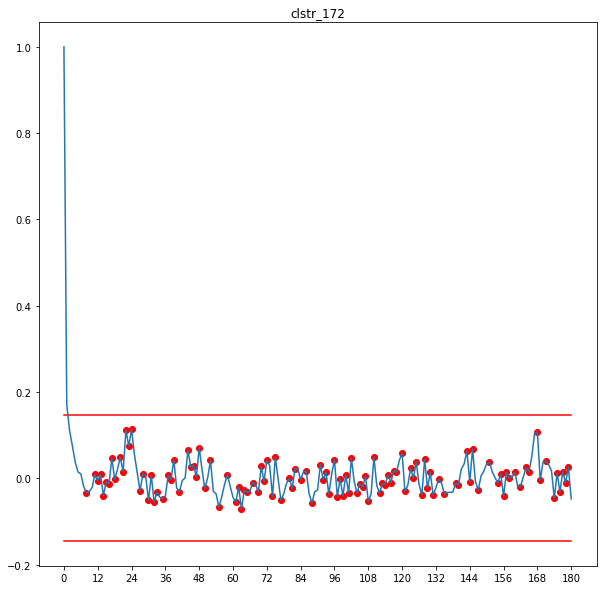

peak index: [  6   7   8   9  10  11  12  14  16  19  20  21  22  24  26  27  28  29
  32  35  36  37  38  40  41  43  44  46  47  48  50  52  55  56  57  58
  60  61  64  65  66  67  68  72  73  74  75  77  79  81  82  84  85  86
  88  90  91  92  94  95  98  99 100 101 102 103 106 108 112 114 115 117
 118 119 121 122 123 126 127 129 131 132 134 139 140 141 142 144 145 146
 147 148 149 150 151 152 153 155 157 158 161 162 163 165 167 169 171 172
 173 174 176 177 178 179]


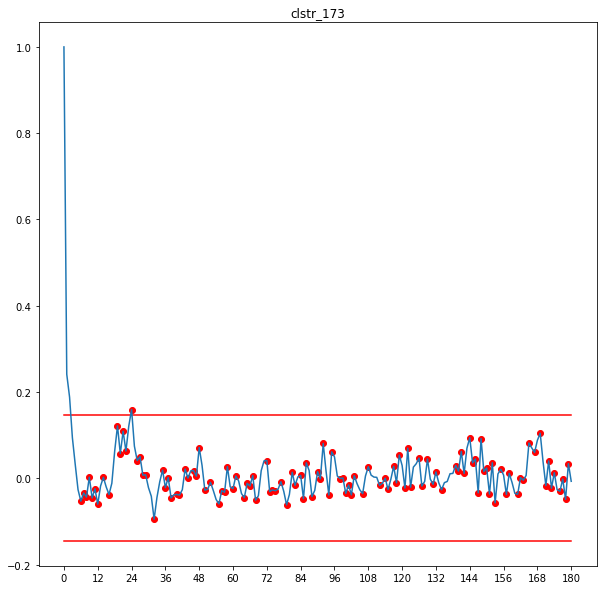

peak index: [  3   4   6   9  10  13  16  18  19  21  22  24  26  27  32  33  34  36
  37  38  40  41  42  44  45  48  50  51  52  53  55  56  59  60  61  62
  65  67  68  69  70  71  72  75  77  78  79  81  82  83  84  86  87  88
  89  90  91  92  93  95 100 101 102 103 104 106 107 108 109 110 113 116
 117 119 120 121 123 124 127 129 134 136 137 138 139 140 141 144 145 146
 150 152 153 155 156 157 158 159 161 162 163 165 166 168 172 176 177 178]


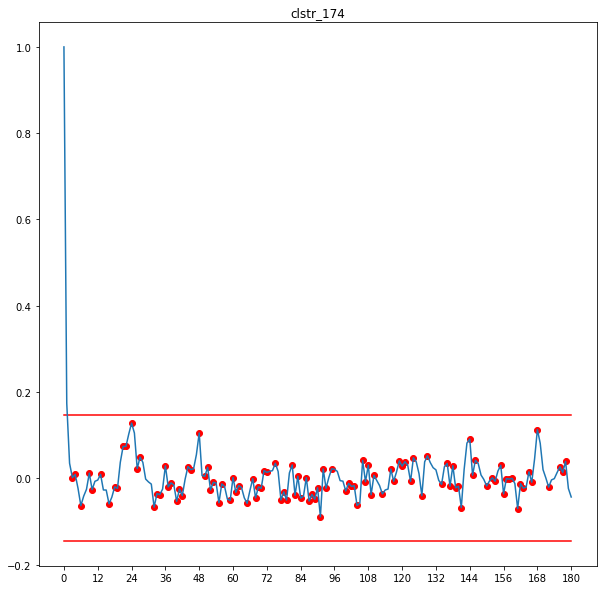

peak index: [  6   9  11  12  13  14  16  17  18  19  20  23  27  28  30  32  33  34
  36  37  38  39  40  41  42  43  45  47  51  52  53  54  55  56  59  61
  65  66  68  71  77  79  80  82  83  84  85  86  88  89  90  91  92  94
  95  96  98 100 102 104 105 106 107 108 109 110 111 112 115 116 118 120
 123 124 125 126 128 132 133 134 136 138 139 144 145 146 147 148 149 150
 152 153 155 157 158 159 160 161 162 163 164 165 166 168 172 175 178 179]


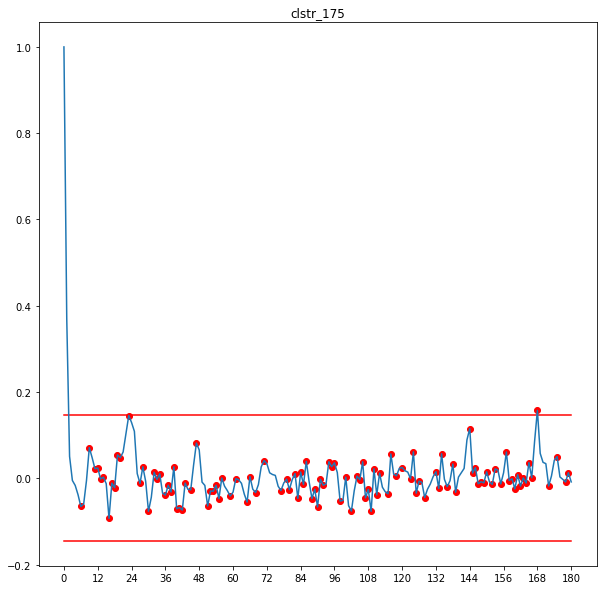

peak index: [  3   4   5   6   7   9  13  14  16  19  20  23  27  28  30  32  33  34
  35  37  38  39  40  41  42  43  44  47  51  52  53  54  55  56  58  59
  60  62  65  66  68  70  71  72  73  74  77  78  80  82  83  84  85  86
  88  89  90  95  99 100 102 105 107 108 109 110 111 112 115 116 118 119
 122 124 125 126 128 129 130 131 133 134 135 136 137 138 139 141 142 144
 145 146 147 149 152 153 155 157 160 161 163 168 172 174 178 179]


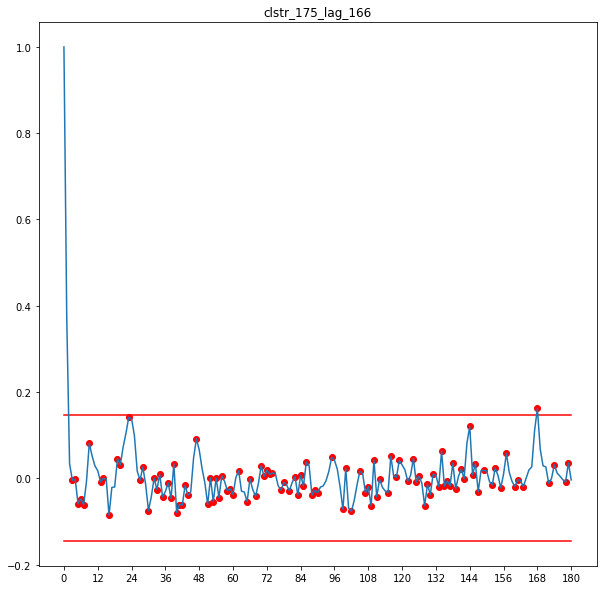

peak index: [  3   4   5   6   7   9  11  12  14  15  16  17  18  19  20  24  27  28
  30  32  33  34  35  37  38  39  40  41  42  44  45  48  51  52  53  54
  55  56  58  59  60  61  65  66  68  70  72  74  76  78  80  82  83  84
  85  87  88  89  90  91  92  95  99 100 102 105 109 110 111 112 114 116
 118 119 122 124 125 126 128 129 130 132 133 134 135 138 139 141 142 144
 145 146 147 149 152 153 154 155 156 157 160 161 163 168 172 174 178]


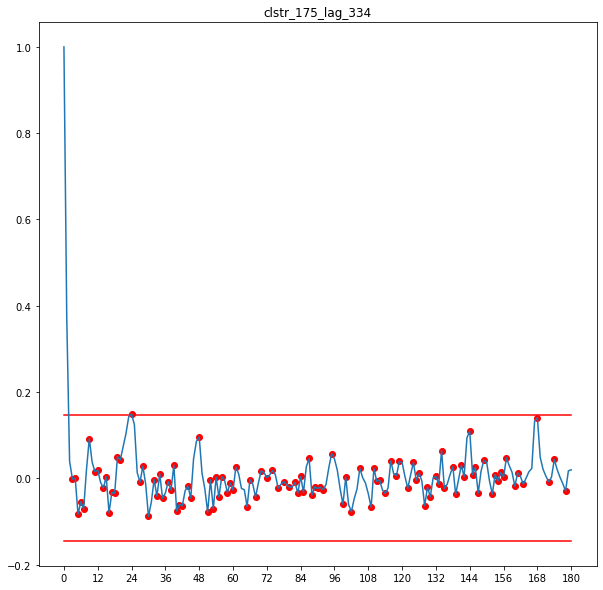

peak index: [  5   6   7   9  11  12  14  15  16  17  18  19  20  24  27  28  30  32
  33  34  35  36  37  39  40  41  42  43  45  48  51  52  53  54  55  56
  58  59  60  61  63  64  65  67  68  70  71  73  74  75  79  80  81  82
  83  84  85  87  88  89  92  95  99 100 102 103 104 105 109 110 114 116
 117 119 122 124 126 127 128 129 130 132 133 134 136 138 139 144 145 146
 147 149 152 153 154 155 156 157 160 162 163 164 165 167 172 174 178]


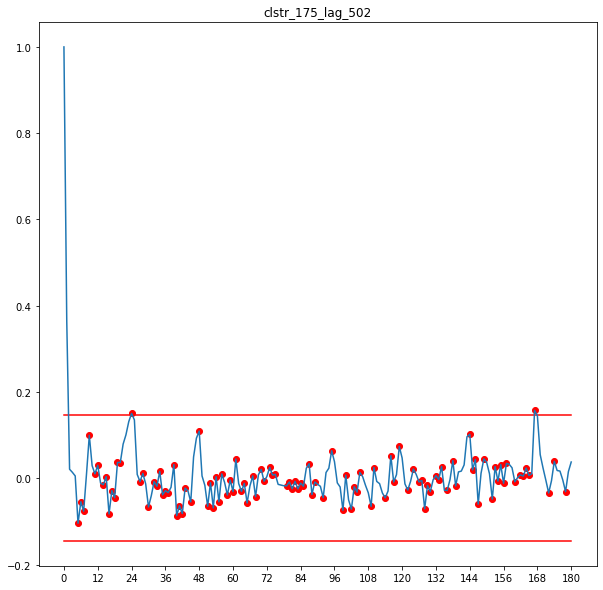

In [19]:
###### PACF plot of ALL numerical time series ###### 
peak_idx_pacf = np.array([])
view_lags = 180
for c in col_names:
    pacf1 = pacf(all_num_ts[c], nlags=view_lags)
    peak_idx_high = np.array((find_peaks(pacf1,height=(-0.4,0.4))[0]),dtype=int)
    peak_idx_low = np.array((find_peaks(-1*pacf1,height=(-0.4,0.4))[0]),dtype=int)
    peak_idx_pacf = np.sort(np.concatenate((peak_idx_high, peak_idx_low),axis=0))
    print(f'peak index: {peak_idx_pacf}')
    x = list(range(0,len(pacf1)))
    plt.figure(figsize=(10,10))
    plt.plot(x,[1.96/np.sqrt(len(x))]*len(x), 'r')
    plt.plot(x,[(-1*1.96)/np.sqrt(len(x))]*len(x),'r')
    plt.plot(x,pacf1)
    plt.xticks(np.arange(0, len(x),12))
    plt.scatter(peak_idx_high,pacf1[peak_idx_high],color='red')
    plt.scatter(peak_idx_low,pacf1[peak_idx_low],color='red')
    plt.title(c)
    plt.show()

# use peak_idx_pacf to pick the first 50 lags

###### PACF plot of ALL numerical time series ######

Friday 7 am to Saturday 7 am


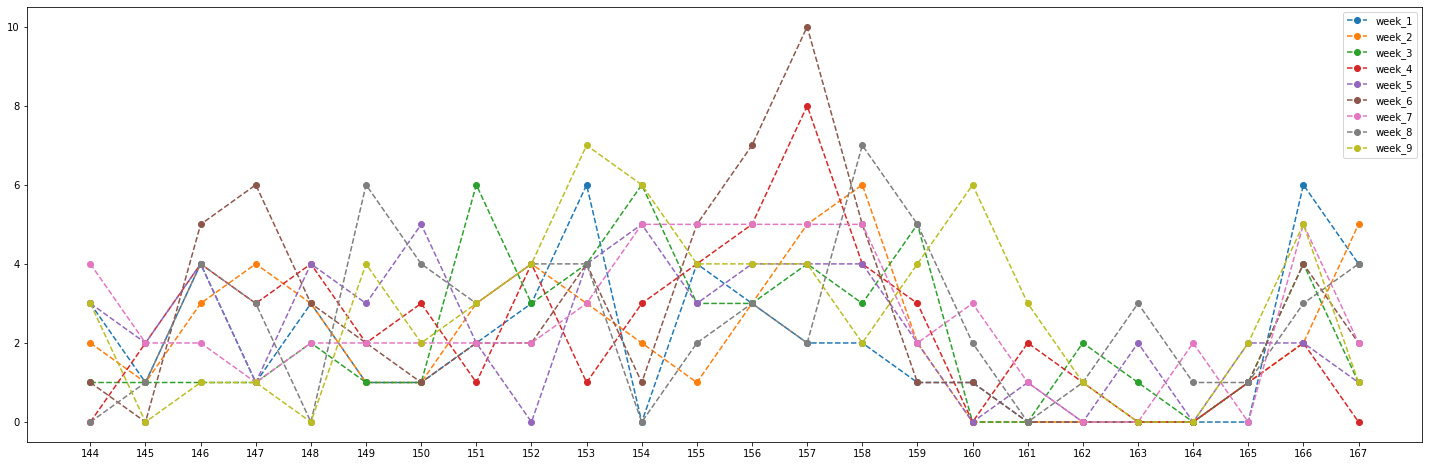

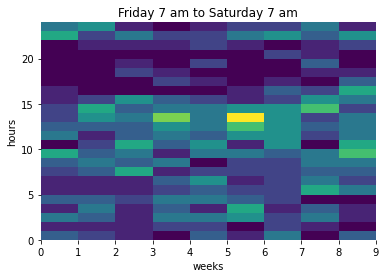

In [20]:
############ Seasonal plot ############ 

### create a pivot table for plot of same day for 9 weeks ###

df = pd.DataFrame()
win_size = 168


for i in range(len(all_num_ts['clstr_'+chosen])//win_size):
    df['week_'+str(i+1)] = all_num_ts['clstr_'+chosen][i*win_size:(i+1)*win_size].to_numpy()

string = 'Friday 7 am to Saturday 7 am'
print(string)
start = 144
end = 168 # day so increment by 24
df_piv = pd.pivot_table(df[start:end],values=df.columns,index=df.index[start:end])
df_piv.plot(figsize=(25,8),xticks=df.index[start:end],linestyle='--', marker='o')


xgrid = np.arange(10)
ygrid = np.arange(25)
xgrid

fig, ax = plt.subplots()
ax.set_title(string)
ax.set_xlabel('weeks')
ax.set_ylabel('hours')
ax.pcolormesh(xgrid, ygrid, df_piv)
ax.set_frame_on(False) # remove all spines

############ Seasonal plot ############ 

week 9, day 1 starts on sunday 8 pm


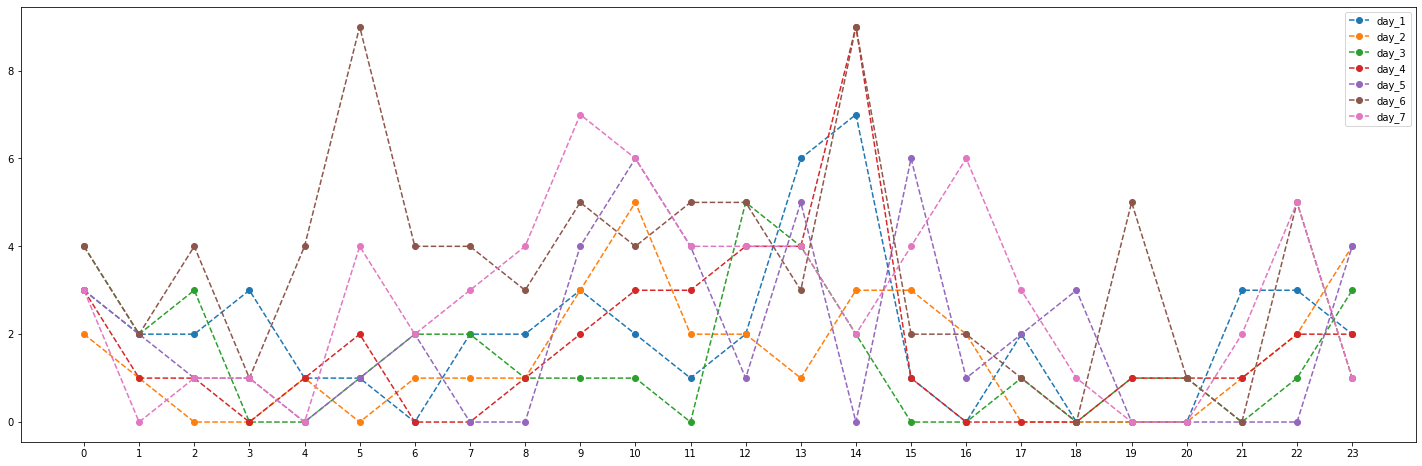

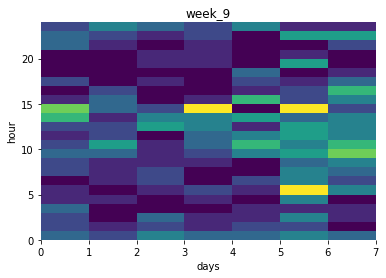

In [21]:
############ Seasonal plot using heat maps ############ 

### create a pivot table for plot all days in a week for 9 weeks ###

df = pd.DataFrame()
win_size = 24

start = 1344 
end = 1512 # week so increment by 168
week = 9
new_ts = all_num_ts['clstr_'+chosen][start:end]

for i in range(len(new_ts)//win_size):
    df['day_'+str(i+1)] = new_ts[i*win_size:(i+1)*win_size].to_numpy()

print('week ' + str(week)+ ', day 1 starts on sunday 8 pm')
df_piv = pd.pivot_table(df,values=df.columns,index=df.index)
df_piv.plot(figsize=(25,8),xticks=df.index,linestyle='--', marker='o')

xgrid = np.arange(8)
ygrid = np.arange(25)
xgrid

fig, ax = plt.subplots()
ax.set_title('week_' + str(week))
ax.set_xlabel('days')
ax.set_ylabel('hour')
ax.pcolormesh(xgrid, ygrid, df_piv)
ax.set_frame_on(False) # remove all spines

############ Seasonal plot using heat maps ############ 

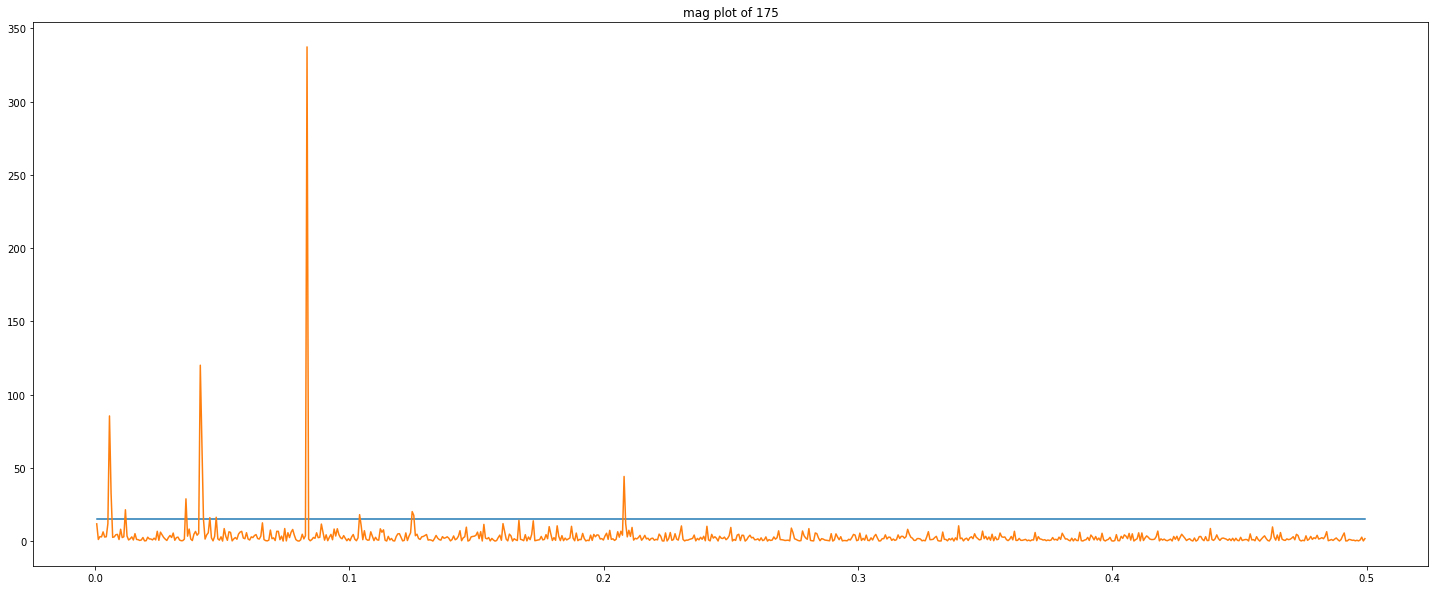

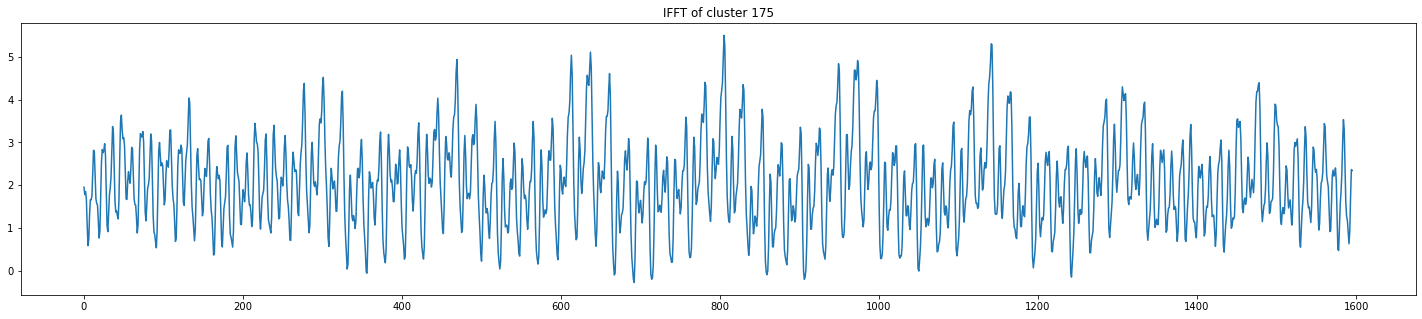

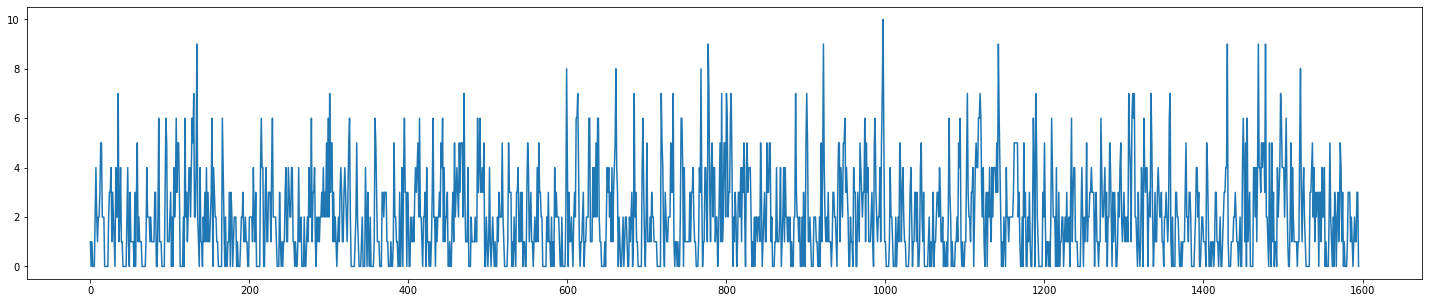

In [70]:
###### IFFT plot of reconstructed time series ######

x = all_num_ts['clstr_'+chosen]

n=len(x)
fhat = np.fft.fft(x,n)
PSD = fhat*np.conj(fhat) / n
freq = (1/n)*np.arange(n)
start=1
L = np.arange(start,np.floor(n/2),dtype='int')
plt.figure(figsize=(25,10))
plt.plot(freq[L],np.array([15]*len(freq[L])))
plt.plot(freq[L],PSD[L])
plt.title('mag plot of '+chosen)
plt.show()


indices = PSD > 15
fhat = fhat*indices

ffilt = np.fft.ifft(fhat)
plt.figure(figsize=(25,5))
plt.plot(np.arange(0,len(x)),ffilt,label='Reconstructed')
plt.title('IFFT of cluster '+chosen)
plt.show()

plt.figure(figsize=(25,5))
plt.title('original cluster '+chosen+' demand')
plt.plot(np.arange(0,len(x)),x,label='original')
plt.show()



###### IFFT plot of reconstructed time series ######

In [ ]:
###### FFT plot of ALL numerical time series ###### 
for c in col_names:
    # apply fast fourier transform and take absolute values
    x = all_num_ts[c]

    ft = np.fft.rfft(x)
    freqs = np.fft.rfftfreq(len(x), 1) # Get frequency axis from the time axis
    mags = abs(ft) # We don't care about the phase information here
    plt.figure(figsize=(25,5))
    plt.xticks(np.arange(min(x), max(x)+1, 0.01))
    plt.title('mag plot of '+c)
    plt.plot(freqs, mags)
    plt.show()

    phs = np.angle(ft)
    plt.plot(freqs, phs)
    plt.title('phase plot of '+c)
    plt.show()
    idx = np.argsort(-1*mags)
    print('Largest magnitude periods in hours' )
    print(1/freqs[idx[0:10]])
    print('Phase of Largest magnitude ',(phs[idx[0:10]]/np.pi) * 180 )
    print('Phase shift in hours ',(phs[idx[0:10]]/np.pi) * (1/freqs[idx[0:10]]) )    


###### FFT plot of ALL numerical time series ###### 

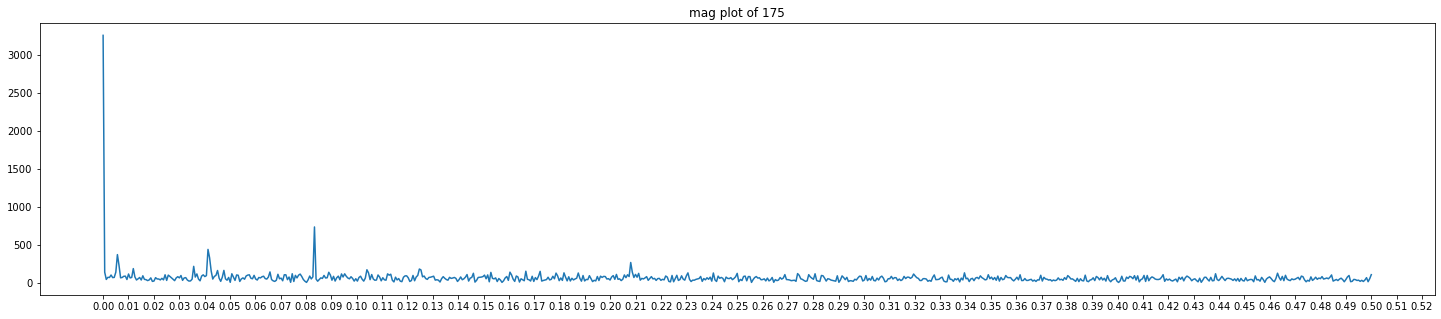

Largest magnitude period =  12.0  hours
Next largest magnitude periods in hours
[         inf  12.          24.18181818 177.33333333  23.82089552
   4.80722892 159.6         28.          84.           8.0201005 ]


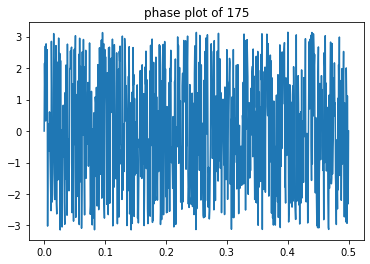

Phase of Largest magnitude  [   0.           -3.50937254  -57.40489271 -172.9690443   113.8525727
  146.9708845    -9.89759185  120.03357372  163.26492553  154.57445701]
Phase shift in hours  [          nan   -0.23395817   -7.71197043 -170.40653994   15.06705688
    3.92512603   -8.77586477   18.67188924   76.19029858    6.88723711]


In [37]:
###### FFT plot of entire chosen time series ###### 

x = all_num_ts['clstr_'+chosen]

ft = np.fft.rfft(x)
freqs = np.fft.rfftfreq(len(x), 1) # Get frequency axis from the time axis
mags = abs(ft) # We don't care about the phase information here
plt.figure(figsize=(25,5))
plt.xticks(np.arange(min(x), max(x)+1, 0.01))
plt.plot(freqs, mags)
plt.title('mag plot of '+chosen)
plt.show()

inflection = np.diff(np.sign(np.diff(mags)))
peaks = (inflection < 0).nonzero()[0] + 1
peak = peaks[mags[peaks].argmax()]
signal_freq = freqs[peak] #
print('Largest magnitude period = ',1/signal_freq, ' hours')


idx = np.argsort(-1*mags)
print('Next largest magnitude periods in hours' )
print(1/freqs[idx[0:10]])

phs = np.angle(ft)
plt.plot(freqs, phs)
plt.title('phase plot of '+chosen)
plt.show()
idx = np.argsort(-1*mags)
print('Phase of Largest magnitude ',(phs[idx[0:10]]/np.pi) * 180 )
print('Phase shift in hours ',(phs[idx[0:10]]/np.pi) * (1/freqs[idx[0:10]]) )    



###### FFT plot of entire chosen time series ###### 

In [ ]:
###### FFT plot of chosen time series every week ###### 

x = all_num_ts['clstr_'+chosen]

win_size = 168

for i in range(len(x)//win_size):
    x_week = x[i*win_size:(i+1)*win_size].to_numpy()

    ft = np.fft.rfft(x_week)
    freqs = np.fft.rfftfreq(len(x_week), 1) # Get frequency axis from the time axis
    mags = abs(ft) # We don't care about the phase information here
    plt.figure(figsize=(25,5))
    plt.xticks(np.arange(min(x_week), max(x_week)+1, 0.01))
    plt.plot(freqs, mags)
    plt.title('mag plot of week '+ str(i+1))
    plt.show()

    inflection = np.diff(np.sign(np.diff(mags)))
    peaks = (inflection < 0).nonzero()[0] + 1
    peak = peaks[mags[peaks].argmax()]
    signal_freq = freqs[peak] #
    print('Largest magnitude period = ',1/signal_freq, ' hours')


    idx = np.argsort(-1*mags)
    print('Next largest magnitude periods in hours' )
    print(1/freqs[idx[0:10]])

    phs = np.angle(ft)
    plt.plot(freqs, phs)
    plt.title('phase plot of '+c)
    plt.show()
    idx = np.argsort(-1*mags)
    print('Phase of Largest magnitude ',(phs[idx[1:10]]/np.pi) * 180 )
    print('Phase shift in hours ',(phs[idx[0:10]]/np.pi) * (1/freqs[idx[0:10]]) )    

###### FFT plot of chosen time series every week ###### 

In [28]:
col_names

dict_keys(['temp_clstr_175', 'hum_clstr_175', 'clstr_126', 'clstr_166', 'clstr_167', 'clstr_168', 'clstr_169', 'clstr_170', 'clstr_171', 'clstr_172', 'clstr_173', 'clstr_174', 'clstr_175', 'clstr_175_lag_166', 'clstr_175_lag_334', 'clstr_175_lag_502'])

correlation between clstr_126,and clstr_175 for 168 lags


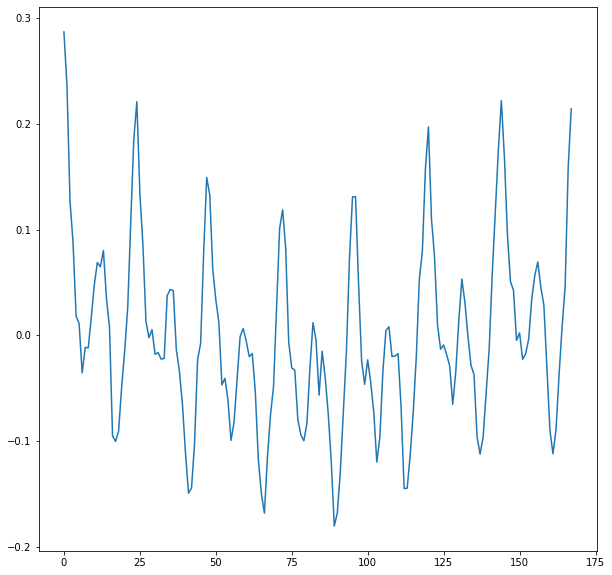

correlation between clstr_166,and clstr_175 for 168 lags


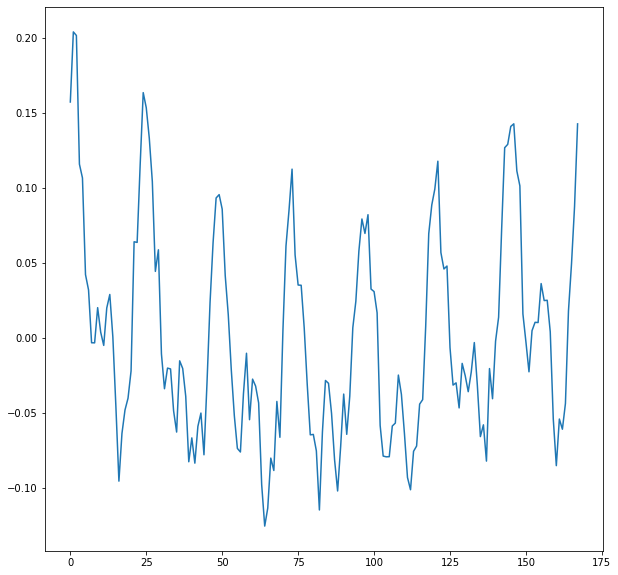

correlation between clstr_167,and clstr_175 for 168 lags


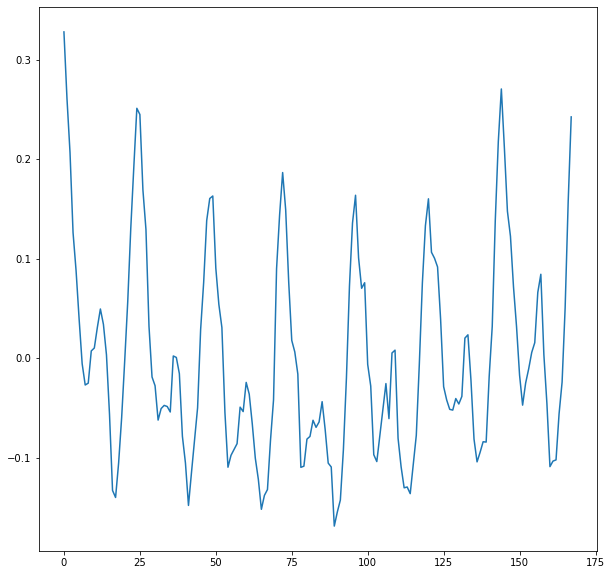

correlation between clstr_168,and clstr_175 for 168 lags


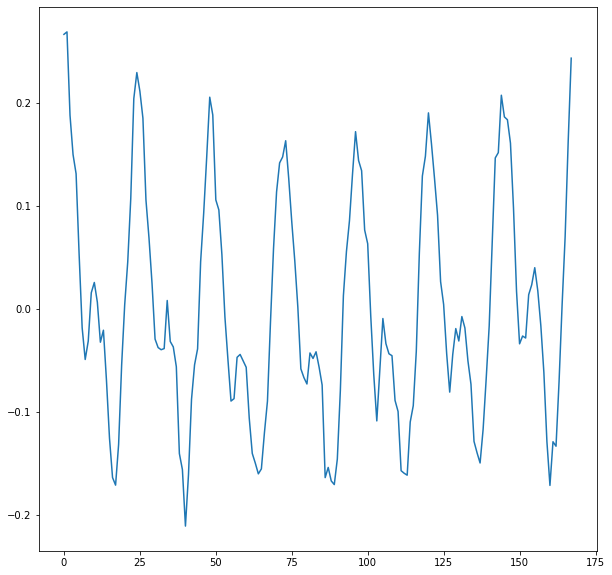

correlation between clstr_169,and clstr_175 for 168 lags


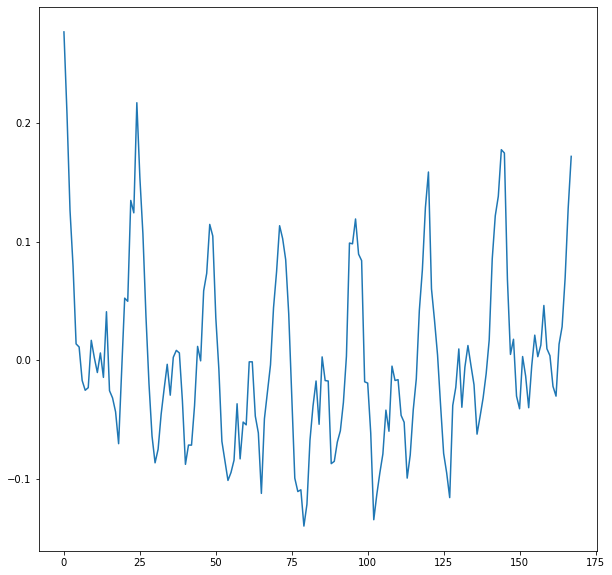

correlation between clstr_170,and clstr_175 for 168 lags


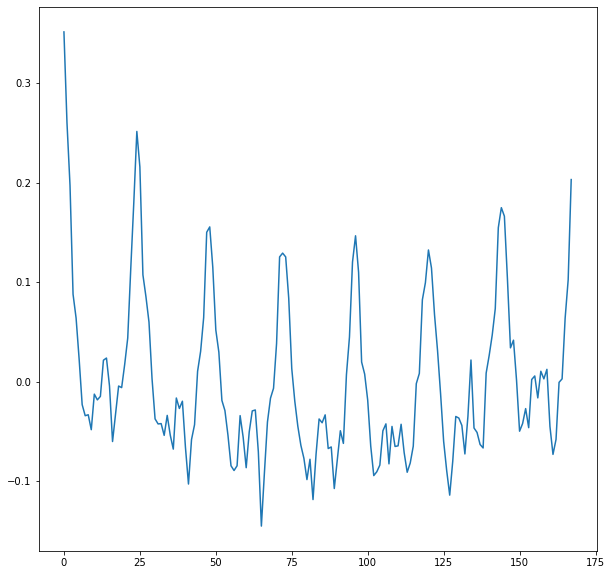

correlation between clstr_171,and clstr_175 for 168 lags


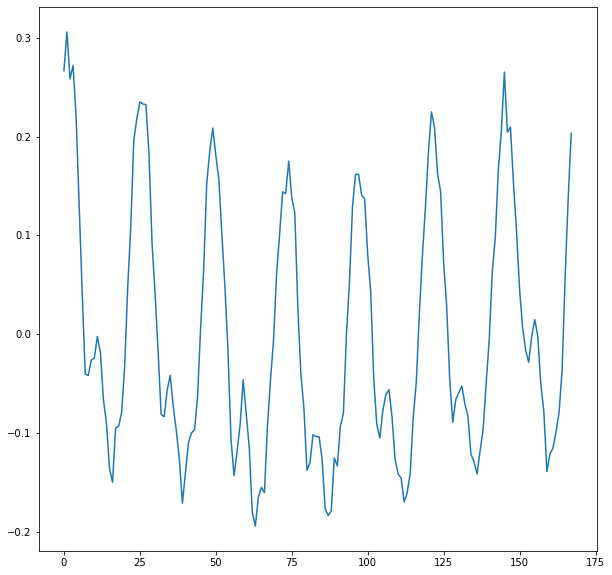

correlation between clstr_172,and clstr_175 for 168 lags


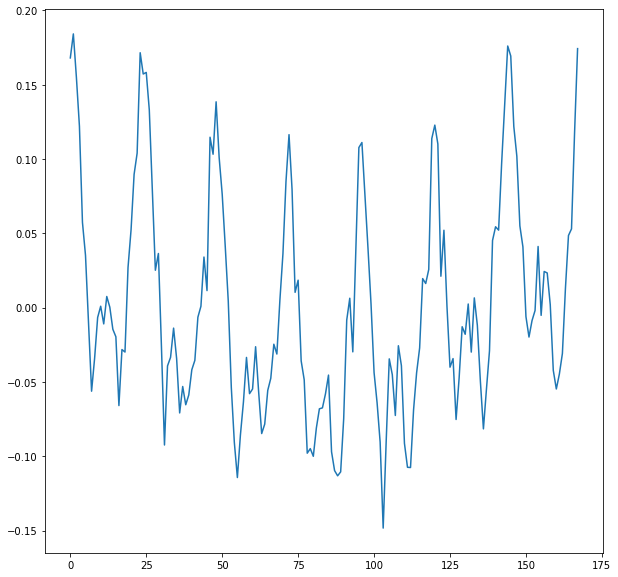

correlation between clstr_173,and clstr_175 for 168 lags


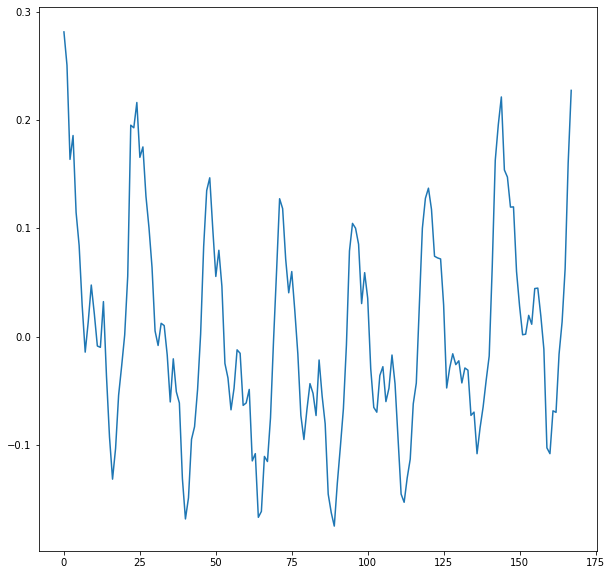

correlation between clstr_174,and clstr_175 for 168 lags


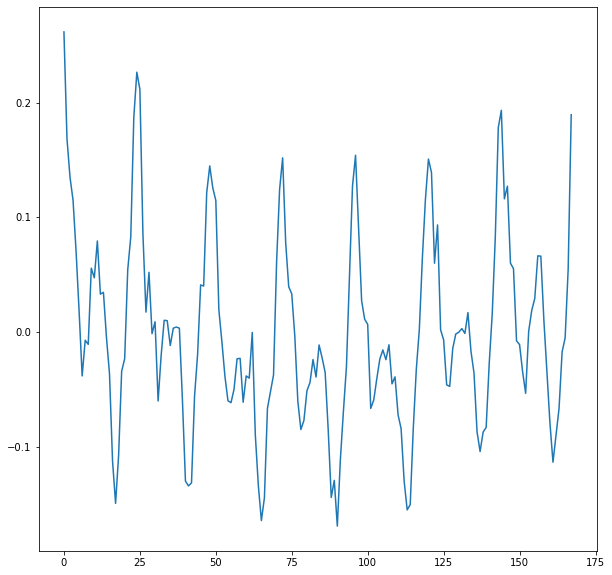

new covariate clusters columns: ['clstr_171', 'clstr_168']


In [29]:
###### Cross correlation plot of ALL demand time series ###### 
'''
# ########## calculate cross correlation between any 2 clusters ##########
# ## create all pairs of cluster demand_data in this region
# all_combi_idx = list(combinations(range(len(list(col_names))-3),2))
# all_demand_cols = list(col_names)[3:] # remove temp, hum, & wind speed
# for i,j in all_combi_idx:
#     ccf1 = sm.tsa.stattools.ccf( all_num_ts[all_demand_cols[i]],  all_num_ts[all_demand_cols[j]], adjusted=False)
#     print(f'correlation between {all_demand_cols[i]},and {all_demand_cols[j]}')
#     plt.plot(ccf1)
#     plt.show()
# ########## calculate cross correlation between any 2 clusters ##########
'''

# ########## calculate cross correlation between chosen cluster and other clusters ##########
all_other_dem_cols = list(col_names)[2:] # remove temp, hum, 
all_other_dem_cols.remove(chosen_clstr)
#all_other_dem_cols.remove('clstr_'+chosen+'_lag_22')
all_other_dem_cols.remove('clstr_'+chosen+'_lag_166')
all_other_dem_cols.remove('clstr_'+chosen+'_lag_334')
all_other_dem_cols.remove('clstr_'+chosen+'_lag_502')

sum_ccf = {} # find which two series has the highest cross correaltion
first_nlags =168
for c in all_other_dem_cols:
    #calculate cross correlation between any 2 clusters
    ccf1 = sm.tsa.stattools.ccf( all_num_ts[chosen_clstr],  all_num_ts[c], adjusted=False)
    sum_ccf[c + " & " + chosen_clstr] = sum(abs(ccf1[:first_nlags]))
    print(f'correlation between {c},and {chosen_clstr} for {first_nlags} lags')
    plt.figure(figsize=(10,10))
    plt.plot(ccf1[:first_nlags])
    plt.show()
# ########## calculate cross correlation between chosen cluster and other clusters ##########

ccf_sorted = dict( sorted(sum_ccf.items(), key=operator.itemgetter(1),reverse=True))

new_covariate_clstr_columns = list(ccf_sorted.keys())[:2] # use the 2 largest CCF clusters as covariates for chosen cluster
new_covariate_clstr_columns = [new_covariate_clstr_columns[0].split(" &")[0] , new_covariate_clstr_columns[1].split(" &")[0]]
print(f'new covariate clusters columns: {new_covariate_clstr_columns}')
###### Cross correlation plot of ALL demand time series ###### 

In [30]:
all_num_ts.keys()

dict_keys(['temp_clstr_175', 'hum_clstr_175', 'clstr_126', 'clstr_166', 'clstr_167', 'clstr_168', 'clstr_169', 'clstr_170', 'clstr_171', 'clstr_172', 'clstr_173', 'clstr_174', 'clstr_175', 'clstr_175_lag_166', 'clstr_175_lag_334', 'clstr_175_lag_502'])

In [31]:
##################  Add inflow columns ################## 
tampines_region_inflow =  pd.read_csv('C:\Work\WORK_PACKAGE\Demand_forecasting\github\DeepAR-pytorch\My_model\\2_freq_nbinom_LSTM\\1_cluster_demand_prediction\data\demand_data\\tampines_region_inflow_medium_dataset_lag_502.csv')
##################  Add inflow columns ################## 


################# Final numerical covariates and response time series  ###############
final_response_ts = {chosen_clstr:all_num_ts[chosen_clstr]}

final_num_covariate_ts = {'temp_clstr_175':temp_clstr_175,'hum_clstr_175':hum_clstr_175, \
new_covariate_clstr_columns[0]:all_num_ts[new_covariate_clstr_columns[0]],\
new_covariate_clstr_columns[1]:all_num_ts[new_covariate_clstr_columns[1]],\
'clstr_'+chosen+'_lag_502':all_num_ts['clstr_'+chosen+'_lag_502'],
'clstr_'+chosen+'_lag_166':all_num_ts['clstr_'+chosen+'_lag_166'],
'clstr_'+chosen+'_lag_334':all_num_ts['clstr_'+chosen+'_lag_334'],
chosen+'_inflow': tampines_region_inflow[chosen], chosen+'_lag_502'+'_inflow': tampines_region_inflow[chosen+'_lag_502'],\
chosen+'_lag_166'+'_inflow': tampines_region_inflow[chosen+'_lag_166'],\
chosen+'_lag_334'+'_inflow': tampines_region_inflow[chosen+'_lag_334'] }


print('final_response_ts', final_response_ts)
print('final_num_covariate_ts', final_num_covariate_ts)

with open("final_response_ts_tampines_medium_dataset_lag_502.pkl",'wb') as f:
    pickle.dump(final_response_ts,f)

with open("final_num_covariate_ts_tampines_medium_dataset_lag_502.pkl",'wb') as f:
    pickle.dump(final_num_covariate_ts,f)
pd.DataFrame(final_num_covariate_ts).to_csv("Clsuter_"+chosen+"_num_ts_dataset.csv")

################# Final numerical covariates and response time series  ###############


final_response_ts {'clstr_175': 0       1
1       0
2       1
3       0
4       0
       ..
1591    1
1592    1
1593    3
1594    3
1595    0
Name: 175, Length: 1596, dtype: int64}
final_num_covariate_ts {'temp_clstr_175': 0       300.01
1       301.07
2       302.19
3       302.22
4       303.22
         ...  
1591    302.13
1592    302.13
1593    301.07
1594    301.07
1595    299.85
Name: temp_clstr_175, Length: 1596, dtype: float64, 'hum_clstr_175': 0       83
1       78
2       70
3       74
4       70
        ..
1591    79
1592    74
1593    83
1594    83
1595    85
Name: hum_clstr_175, Length: 1596, dtype: int64, 'clstr_171': 0       1
1       1
2       1
3       2
4       1
       ..
1591    4
1592    1
1593    3
1594    0
1595    0
Name: 171, Length: 1596, dtype: int64, 'clstr_168': 0       0
1       2
2       3
3       0
4       1
       ..
1591    6
1592    2
1593    2
1594    3
1595    0
Name: 168, Length: 1596, dtype: int64, 'clstr_175_lag_502': 0       1
1       1
2       

In [32]:
final_num_covariate_ts.keys()

dict_keys(['temp_clstr_175', 'hum_clstr_175', 'clstr_171', 'clstr_168', 'clstr_175_lag_502', 'clstr_175_lag_166', 'clstr_175_lag_334', '175_inflow', '175_lag_502_inflow', '175_lag_166_inflow', '175_lag_334_inflow'])

In [33]:
###############
# TODO CHECK that each hour of any 24 hour random period can be modelled by a negative binomial distribution
# check the goodness of fit. 

################

In [34]:
################# Final categorical covariates time series  ###############
final_cat_covariate_ts = {"wea_desc_clstr_175":tampines_clstr_175__weather["wea_desc_clstr_175"].astype(dtype=str)}

with open("final_cat_covariate_ts_tampines_medium_dataset_lag_502.pkl",'wb') as f:
    pickle.dump(final_cat_covariate_ts,f)
pd.DataFrame(final_cat_covariate_ts).to_csv("Clsuter_"+chosen+"_cat_ts_dataset.csv")
################# Final categorical covariates time series  ###############


In [35]:
with open("final_cat_covariate_ts_tampines_medium_dataset_lag_502.pkl",'rb') as f:
    final_cat_covariate_ts = pickle.load(f)

final_cat_covariate_ts.keys()

dict_keys(['wea_desc_clstr_175'])